# Partionnement de données textuelles : hymnes nationaux de 190 pays.

# Introduction

Nous allons travailler sur un dataset contenant les hymnes nationaux de 190 pays du monde.  

L'intérêt de la démarche est de dégager l'identité nationale de chaque pays et de faire des regroupements par thématiques.  

Nous nous intéressons principalement à la colonne "Anthem", qui contient le texte de l'hymne de chaque pays. Notre objectif est de partitionner ces textes en groupes homogènes, en utilisant des techniques de prétraitement du texte et des méthodes de partitionnement.

Les groupes seront désignés sous l'appelation "clusters". Nous allons utiliser deux techniques différentes :
- le partitionnement en k-moyennes
- le partitionnement hiérarchique

Nous utiliserons les méthodes du coude et la méthode silhouette pour tenter de déterminer la valeur optimale de clusters pour effecter un partionnement efficace.

Les textes devront être prétraités à l'aide des techniques de :
- lemmatisation
- tokenisation
- vectorisation

Ce travail devrait permettre de dégager des thématiques par clusters que nous tenterons d'analyser.

# Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
os.getcwd()

'/content'

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/4MLUP/script/fonctions_rol.py'

# Importez les fonctions du fichier
import imp
fonctions_rol = imp.load_source('fonctions', path)

In [ ]:
# from fonctions_rol import df_info, distribution, detect_outliers, sns_plot, create_dropdown

In [ ]:
df_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/4MLUP/anthems.csv')
df_main

Country Alpha-2 Alpha-3 Continent  \
0           Albania      AL     ALB    Europe   
1           Armenia      AM     ARM    Europe   
2           Austria      AT     AUT    Europe   
3        Azerbaijan      AZ     AZE    Europe   
4           Belarus      BY     BLR    Europe   
..              ...     ...     ...       ...   
185         Tunisia      TN     TUN    Africa   
186          Uganda      UG     UGA    Africa   
187  Western Sahara      EH     ESH    Africa   
188          Zambia      ZM     ZMB    Africa   
189        Zimbabwe      ZW     ZWE    Africa   

                                                Anthem  
0    Around our flag we stand united, With one wish...  
1    Our Fatherland, free, independent, That has fo...  
2    Land of mountains, land by the river, Land of ...  
3    Azerbaijan, Azerbaijan! The glorious Fatherlan...  
4    We, Belarusians, are peaceful people, Wholehea...  
..                                                 ...  
185  O defenders of the Homeland! Rally around to t...  
186  Oh Uganda! May God uphold Thee, We lay our fut...  
187  O sons of the Sahara! In the battlefield, you ...  
188  Stand and sing of Zambia, proud and free, Land...  
189  Oh lift high the banner, the flag of Zimbabwe ...  

[190 rows x 5 columns]

# Exploration et préparation

## df_info()

In [ ]:
fonctions_rol.df_info(df_main).iloc[:,:7]


    Longueur du dataset : 190 enregistrements
    Nombre de colonnes : 5
    Nombre de colonnes numériques : 0
    Nombre de colonnes catégorielles : 5
    Nombre de valeurs manquantes : 1
    


type                                        Echantillon  \
Country    object  ['Albania', 'Armenia', 'Austria', 'Azerbaijan'...   
Alpha-2    object                     ['AL', 'AM', 'AT', 'AZ', 'BY']   
Alpha-3    object                ['ALB', 'ARM', 'AUT', 'AZE', 'BLR']   
Continent  object  ['Europe', 'Europe', 'Europe', 'Europe', 'Euro...   
Anthem     object  ['Around our flag we stand united, With one wi...   

           Nbr V manquantes  % de V manquantes  Nbr L dupliquées  \
Country                   0               0.00                 0   
Alpha-2                   1               0.53                 0   
Alpha-3                   0               0.00                 0   
Continent                 0               0.00                 0   
Anthem                    0               0.00                 0   

           Nbr V unique                                               Mode  
Country             190                                        Afghanistan  
Alpha-2             188                                                 CH  
Alpha-3             190                                                AFG  
Continent             6                                             Africa  
Anthem              188  Arise, ye who refuse to be slaves; With our ve...

Observation du jeu de données :
- Le dataset contient 190 lignes, qui correspondent à 190 pays identifiés par les colonnes **Country**, **Alpha-2** et **Alpha-3**.
- Nous avons également l'information du **Continent** du pays considéré, cette colonne ne nous sera pas utile pour le traiment.  
- Le dataset contient uniquement des colonnes catégorielles.
- Il y a 1 valeur manquante pour la colonne **Alpha-2**.  
-Le code **Alpha-2** a 188 valeurs uniques pour 190 pays, il y a donc des doublons ou nan.
- De même pour **Antheme**.
- La colonne **Antheme** contient donc les textes que nous avons à analyser.  

## Doublons

In [ ]:
df = df_main.copy()

In [ ]:
df[df.duplicated(subset=['Alpha-2'], keep=False)]

Country Alpha-2 Alpha-3      Continent  \
41  Switzerland      CH     CHE         Europe   
47        Chile      CH     CHL  South_America   

                                               Anthem  
41  When the morning skies grow red, and over us t...  
47  Beloved Homeland, receive the vows That Chile ...

Ce doublon n'est pas une erreur,  
De plus, La colonne Alpha-2 ayant également une valeur manquante pour la Namibie, on a identifié les deux valeurs manquantes, cependant :  
**=> La colonne Alpha-2 étant  moins fiable que Alpha-3 elle peut être retirée.**

In [ ]:
df[df.duplicated(subset=['Anthem'], keep=False)]

Country Alpha-2 Alpha-3 Continent  \
9    Cyprus      CY     CYP    Europe   
17   Greece      GR     GRC    Europe   
96    China      CN     CHN      Asia   
109   Macau      MO     MAC      Asia   

                                                Anthem  
9    We knew thee of old, O, divinely restored, By ...  
17   We knew thee of old, O, divinely restored, By ...  
96   Arise, ye who refuse to be slaves; With our ve...  
109  Arise, ye who refuse to be slaves; With our ve...

Ces doublons ne sont pas des erreurs :
Ce sont des pays ayant le même hymne.

## Préparation

Une recherche internet indique que le code de la Namibie est NA ou NAM.
[https://www.iso.org/obp/ui/#iso:code:3166:NA](https://www.iso.org/obp/ui/#iso:code:3166:NA)

In [ ]:
def data_preparation(df):
    # Compléter pour la Namibie
    # df.loc[df['Country'] == 'Namibia', 'Alpha-2'] = 'NA'
    df.loc[df['Country'] == 'Namibia', 'Alpha-3'] = 'NAM'
    # Retirer Alpha-2
    df.drop('Alpha-2',axis=1,inplace=True)
    return df
df = data_preparation(df)
df

Country Alpha-3 Continent  \
0           Albania     ALB    Europe   
1           Armenia     ARM    Europe   
2           Austria     AUT    Europe   
3        Azerbaijan     AZE    Europe   
4           Belarus     BLR    Europe   
..              ...     ...       ...   
185         Tunisia     TUN    Africa   
186          Uganda     UGA    Africa   
187  Western Sahara     ESH    Africa   
188          Zambia     ZMB    Africa   
189        Zimbabwe     ZWE    Africa   

                                                Anthem  
0    Around our flag we stand united, With one wish...  
1    Our Fatherland, free, independent, That has fo...  
2    Land of mountains, land by the river, Land of ...  
3    Azerbaijan, Azerbaijan! The glorious Fatherlan...  
4    We, Belarusians, are peaceful people, Wholehea...  
..                                                 ...  
185  O defenders of the Homeland! Rally around to t...  
186  Oh Uganda! May God uphold Thee, We lay our fut...  
187  O sons of the Sahara! In the battlefield, you ...  
188  Stand and sing of Zambia, proud and free, Land...  
189  Oh lift high the banner, the flag of Zimbabwe ...  

[190 rows x 4 columns]

In [ ]:
fonctions_rol.df_info(df).iloc[:,:4]


    Longueur du dataset : 190 enregistrements
    Nombre de colonnes : 4
    Nombre de colonnes numériques : 0
    Nombre de colonnes catégorielles : 4
    Nombre de valeurs manquantes : 0
    


type                                        Echantillon  \
Country    object  ['Albania', 'Armenia', 'Austria', 'Azerbaijan'...   
Alpha-3    object                ['ALB', 'ARM', 'AUT', 'AZE', 'BLR']   
Continent  object  ['Europe', 'Europe', 'Europe', 'Europe', 'Euro...   
Anthem     object  ['Around our flag we stand united, With one wi...   

           Nbr V manquantes  % de V manquantes  
Country                   0                0.0  
Alpha-3                   0                0.0  
Continent                 0                0.0  
Anthem                    0                0.0

Le dataset ne contient plus de valeurs manquantes.

## Datavisualisation

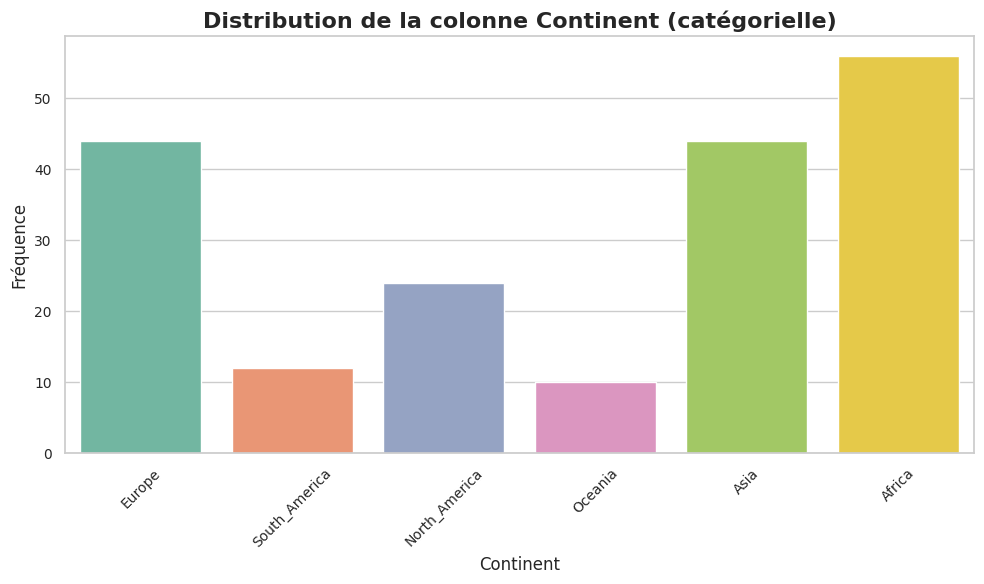

In [ ]:
fonctions_rol.distribution(df,'Continent')

On peut observer les Continents ayant le plus de pays identifiés dans cette liste (Afrique et Europe en tête).

# Pré-traitement des textes

## Tokenisation
Il est possible d'utiliser word_tokenize() de NLTK qui automatise les traitements.  
On va préférer ici décomposer les étapes pour s'en passer en utilisant Spacy pour la Lemmatisation

## Lemmatisation
- On peut utiliser WordNetLemmatizer qui est une une base de données lexicale et sémantique.
- Ou Spacy qui a une approche statistique.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### WordNEt
[https://www.nltk.org/_modules/nltk/stem/wordnet.html](https://www.nltk.org/_modules/nltk/stem/wordnet.html)

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
class TextPreprocessorWordNet:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stopwords = set(stopwords.words('english'))

    def preprocess(self, text):
        # Convertir le texte en minuscules
        text = text.lower()

        # Supprimer les caractères spéciaux et la ponctuation
        text = re.sub(r"[^a-zA-Z0-9]", " ", text)
        text = re.sub(r'\W', ' ', text)

        # Supprimer les espaces vides, les stopwords et les mots de moins de 2 lettres.
        tokens = text.split()
        tokens = [token for token in tokens if token not in self.stopwords and len(token) >= 3]

        # Lemmatisation des mots avec WordNet
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        # Rejoindre les tokens pour former une chaîne de texte
        processed_text = ' '.join(tokens)

        return processed_text

# Utilisation du préprocesseur de texte
preprocessor_wordnet = TextPreprocessorWordNet()

### Spacy
[https://spacy.io/usage/models](https://spacy.io/usage/models)

In [ ]:
import spacy

In [ ]:
class TextPreprocessorSpacy:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
        self.stopwords = set(stopwords.words('english'))

    def preprocess(self, text):
        # Convertir le texte en minuscules
        text = text.lower()

        # Supprimer les caractères spéciaux et la ponctuation
        # text = re.sub(r"[^a-zA-Z0-9]", " ", text)
        text = re.sub(r'\W', ' ', text)

        # Supprimer les espaces vides, les stopwords et les mots de moins de 2 lettres.
        tokens = text.split()
        tokens = [token for token in tokens if token not in self.stopwords and len(token) >= 3]

        # Lemmatisation des mots avec SpaCy
        doc = self.nlp(" ".join(tokens))
        tokens = [token.lemma_ for token in doc]

        # Rejoindre les tokens pour former une chaîne de texte
        processed_text = ' '.join(tokens)

        return processed_text

# Déclaration du préprocesseur
preprocessor_spacy = TextPreprocessorSpacy()

In [ ]:
# Appliquer le prétraitement des textes sur la colonne "Anthem"
df['Anthem_cleaned_wordnet'] = df['Anthem'].apply(preprocessor_wordnet.preprocess)
df['Anthem_cleaned_spacy'] = df['Anthem'].apply(preprocessor_spacy.preprocess)

In [ ]:
serie1 = df['Anthem_cleaned_wordnet']
serie1

0      around flag stand united one wish one goal sac...
1      fatherland free independent century lived summ...
2      land mountain land river land field land cathe...
3      azerbaijan azerbaijan glorious fatherland valo...
4      belarusian peaceful people wholeheartedly devo...
                             ...                        
185    defender homeland rally around glory time bloo...
186    uganda may god uphold thee lay future thy hand...
187    son sahara battlefield torch holder long road ...
188    stand sing zambia proud free land work joy uni...
189    lift high banner flag zimbabwe symbol freedom ...
Name: Anthem_cleaned_wordnet, Length: 190, dtype: object

In [ ]:
serie2 = df['Anthem_cleaned_spacy']
serie2

0      around flag stand unite one wish one goal sacr...
1      fatherland free independent century live summo...
2      land mountains land river land field land cath...
3      azerbaijan azerbaijan glorious fatherland valo...
4      belarusian peaceful people wholeheartedly devo...
                             ...                        
185    defender homeland rally around glory time bloo...
186    uganda may god uphold thee lie future thy hand...
187    son sahara battlefield torch holder long road ...
188    stand sing zambia proud free land work joy uni...
189    lift high banner flag zimbabwe symbol freedom ...
Name: Anthem_cleaned_spacy, Length: 190, dtype: object

### Comparaison WordNet et Spacy

- Nous pouvons utiliser la librairie *difflib* pour comparer les chaines de caractères.

- Cette librairie fournit des fonctionnalités pour comparer des séquences et générer des différences entre elles.

- L'espace en début de ligne indique qu'il s'agit d'un élément commun aux deux lignes.
- Le signe - suivi d'un mot indique que ce mot est présent dans la première ligne mais pas dans la deuxième.
- Le signe + suivi d'un mot indique que ce mot est présent dans la deuxième ligne mais pas dans la première.
- Le signe ? indique une incertitude ou une différence de format.
- Le signe --- indique un mot qui a été supprimé dans la deuxième ligne par rapport à la première.
- Le signe +++ indique un mot qui a été ajouté dans la deuxième ligne par rapport à la première.

In [ ]:
import difflib

In [ ]:
total_difference = 0
num_lines = len(serie1)

for i in range(num_lines):
    ligne_serie1 = serie1[i]
    ligne_serie2 = serie2[i]

    diff = difflib.ndiff(ligne_serie1.split(), ligne_serie2.split())
    differences = ' '.join(diff)

    print(f"Série 1 - Ligne {i+1}:")
    print(ligne_serie1)
    print()

    print(f"Série 2 - Ligne {i+1}:")
    print(ligne_serie2)
    print()

    similarity = difflib.SequenceMatcher(None, ligne_serie1, ligne_serie2).ratio()
    print(f"Score de similarité - Ligne {i+1}: {round(similarity*100, 1)}%")
    print(f"Différences - Ligne {i+1}:")
    print(differences)
    print()

    # Calculer la différence et l'ajouter au total
    total_difference += similarity

# Calculer la différence moyenne
difference_moyenne = total_difference / num_lines
print(f"Similarité moyenne : {round(difference_moyenne*100, 1)}%")


Série 1 - Ligne 1:
around flag stand united one wish one goal sacred oath bestow upon proclaiming loyalty salvation war abstains traitor born true man frightened dy warrior cause weapon hand brandished defend fatherland sacred right weã relinquish foe place land god proclaimed nation earth shall wane yet live thrive albania fight flag flag sacred symbol upon swear albania dear fatherland honour glory brave man named honoured one sacrificed fatherland forever remembered earth saint

Série 2 - Ligne 1:
around flag stand unite one wish one goal sacred oath bestow upon proclaim loyalty salvation war abstain traitor bear true man frighten die warrior cause weapon hand brandish defend fatherland sacred right weã relinquish foe place land god proclaim nations earth shall wane yet live thrive albania fight flag flag sacred symbol upon swear albania dear fatherland honour glory brave man name honour one sacrifice fatherland forever remember earth saint

Score de similarité - Ligne 1: 13.1%
Diff

Il y a de nombreuses différence entre les deux méthodes.

Spacy semble effectuer une lemmatisation plus radicale et sera probablement préféré pour la suite du traitement.

On peut mettre ces deux méthodes en compétition pour la suite, cependant avec une **similarité moyenne supérière à 80% (cf dernière ligne)**, on ne s'attends pas à trouver de grand écarts.

Pour une première itération aucun stopword personnalisé n'est rajouté, mais ce pourrait être une étape à considérer.


# Vectorisation
Il existe plusieurs méthodes pour vectoriser le texte :

* One-hot encoding :
 * Chaque mot unique du corpus (l'ensemble des textes) est représenté par un vecteur de la taille du vocabulaire. Le vecteur est rempli de zéros, sauf à l'indice qui correspond au mot, où il est mis à un.
 * C'est la méthode la plus simple, mais elle peut rapidement devenir inefficace en termes de mémoire pour de grands corpus car elle crée des vecteurs de très grande dimension (égal à la taille du vocabulaire).
* Count vectorization (ou "Bag of Words")
 * Chaque document est représenté par un vecteur de la taille du vocabulaire. Le vecteur est rempli avec le nombre de fois que chaque mot apparaît dans le document.
 * Cette méthode est simple et efficace, mais elle ne tient pas compte de l'ordre des mots et donne le même poids à tous les mots, quelle que soit leur fréquence d'apparition dans le corpus.
* TF-IDF vectorization
 *  C'est une amélioration du Bag of Words qui donne plus de poids aux mots qui sont uniques pour un document particulier, mais rarement dans le corpus en général.
* Word embeddings :
 * Au lieu de traiter chaque mot comme une entité distincte, cette méthode représente chaque mot par un vecteur dens. Un "vecteur dense" signifie que la plupart des valeurs dans le vecteur sont des nombres non nuls. Chaque dimension dans un word embedding n'a pas de sens par elle-même, mais l'ensemble du vecteur capture la sémantique du mot. Ils sont généralement plus petits, cela les rend plus efficaces à stocker et à calculer.
  * Plus complexes mais elles capables de capturer des relations sémantiques entre les mots et peuvent donner de meilleurs résultats pour certaines tâches.

- One-hot encoding semble à éviter, et count vectorisation n'est peut être pas le plus pertinent pour un corpus d'hymnes, qui sont des textes assez courts.
- On pourra utiliser TF-IDF pour une première itération.

## TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Vectorisation des textes
vectorizer = TfidfVectorizer()
text_vectors_spacy = vectorizer.fit_transform(df['Anthem_cleaned_spacy'])
tfidf_spacy = pd.DataFrame(text_vectors_spacy.toarray(), columns=vectorizer.get_feature_names_out())
text_vectors_wordnet = vectorizer.fit_transform(df['Anthem_cleaned_wordnet'])
tfidf_wordnet = pd.DataFrame(text_vectors_wordnet.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
tfidf_wordnet.head()

4th  abandon  abanyarwanda  abide  ablaze  able  abound  abounds  absolute  \
0  0.0      0.0           0.0    0.0     0.0   0.0     0.0      0.0       0.0   
1  0.0      0.0           0.0    0.0     0.0   0.0     0.0      0.0       0.0   
2  0.0      0.0           0.0    0.0     0.0   0.0     0.0      0.0       0.0   
3  0.0      0.0           0.0    0.0     0.0   0.0     0.0      0.0       0.0   
4  0.0      0.0           0.0    0.0     0.0   0.0     0.0      0.0       0.0   

   abstains  ...  zeal  zealand  zealous  zenith  zimbabwe  zion  ºciuszko  \
0  0.150264  ...   0.0      0.0      0.0     0.0       0.0   0.0       0.0   
1  0.000000  ...   0.0      0.0      0.0     0.0       0.0   0.0       0.0   
2  0.000000  ...   0.0      0.0      0.0     0.0       0.0   0.0       0.0   
3  0.000000  ...   0.0      0.0      0.0     0.0       0.0   0.0       0.0   
4  0.000000  ...   0.0      0.0      0.0     0.0       0.0   0.0       0.0   

   ãƒâ   œending  šawice  
0  0.0  0.000000     0.0  
1  0.0  0.000000     0.0  
2  0.0  0.000000     0.0  
3  0.0  0.094711     0.0  
4  0.0  0.000000     0.0  

[5 rows x 3314 columns]

In [ ]:
tfidf_spacy.head()

4th  abandon  abanyarwanda  abide  ablaze  able  abound  absolute  \
0  0.0      0.0           0.0    0.0     0.0   0.0     0.0       0.0   
1  0.0      0.0           0.0    0.0     0.0   0.0     0.0       0.0   
2  0.0      0.0           0.0    0.0     0.0   0.0     0.0       0.0   
3  0.0      0.0           0.0    0.0     0.0   0.0     0.0       0.0   
4  0.0      0.0           0.0    0.0     0.0   0.0     0.0       0.0   

    abstain  abundance  ...  zeal  zealand  zealous  zenith  zimbabwe  zion  \
0  0.152492        0.0  ...   0.0      0.0      0.0     0.0       0.0   0.0   
1  0.000000        0.0  ...   0.0      0.0      0.0     0.0       0.0   0.0   
2  0.000000        0.0  ...   0.0      0.0      0.0     0.0       0.0   0.0   
3  0.000000        0.0  ...   0.0      0.0      0.0     0.0       0.0   0.0   
4  0.000000        0.0  ...   0.0      0.0      0.0     0.0       0.0   0.0   

   ºciuszko  ãƒâ     œende  šawice  
0       0.0  0.0  0.000000     0.0  
1       0.0  0.0  0.000000     0.0  
2       0.0  0.0  0.000000     0.0  
3       0.0  0.0  0.095594     0.0  
4       0.0  0.0  0.000000     0.0  

[5 rows x 2976 columns]

# KMeans : 1ère itération sans optimisation

Le principe de l'algorithme k-means est une technique de clustering non supervisée utilisée pour regrouper un ensemble de données en différents groupes homogènes.

L'algorithme k-means cherche à minimiser l'inertie intra-cluster, qui mesure la somme des distances entre chaque point de données et le centre de cluster de son groupe respectif.

En trouvant les positions optimales des centres de cluster, l'algorithme k-means vise à maximiser la similarité des points de données à l'intérieur de chaque cluster et à minimiser la similarité entre les clusters différents.

On choisit arbitrairement de faire 5 clusters juste pour observer des premiers résultats.

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# Appliquer l'algorithme de partitionnement avec K-means exemple avec 5 clusters (arbitrairement)
def part_kmeans(text_vectors):
  kmeans = KMeans(n_clusters=5, n_init='auto', random_state=42)
  kmeans.fit(text_vectors)
  # Obtenir les labels de partitionnement
  labels = kmeans.labels_
  return labels

In [ ]:
text_vectors_spacy.shape

(190, 2976)

In [ ]:
labels_spacy = part_kmeans(text_vectors_spacy)
labels_spacy

array([3, 2, 4, 1, 2, 3, 3, 2, 3, 1, 4, 3, 1, 4, 3, 1, 3, 1, 2, 0, 4, 3,
       2, 3, 1, 4, 3, 2, 1, 3, 4, 4, 1, 3, 2, 2, 3, 3, 3, 3, 4, 4, 4, 3,
       1, 3, 0, 3, 1, 1, 4, 1, 1, 1, 3, 1, 4, 1, 1, 4, 2, 3, 3, 1, 1, 4,
       2, 1, 4, 3, 2, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 1, 2, 4, 3, 2,
       3, 3, 4, 2, 1, 1, 2, 3, 3, 3, 3, 0, 1, 0, 0, 3, 2, 2, 2, 2, 2, 3,
       0, 1, 2, 3, 2, 2, 2, 2, 4, 4, 1, 2, 1, 0, 1, 1, 2, 1, 1, 2, 2, 2,
       3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 2, 3, 1, 1, 3,
       3, 1, 1, 1, 4, 4, 2, 1, 1, 1, 2, 2, 1, 4, 3, 1, 1, 1, 2, 4, 2, 3,
       2, 1, 3, 3, 1, 4, 3, 2, 1, 3, 3, 2, 3, 3], dtype=int32)

In [ ]:
text_vectors_wordnet.shape

(190, 3314)

In [ ]:
labels_wordnet = part_kmeans(text_vectors_wordnet)
labels_wordnet

array([3, 2, 4, 1, 2, 3, 3, 2, 3, 1, 4, 3, 1, 4, 3, 1, 3, 1, 2, 0, 4, 3,
       3, 3, 1, 4, 3, 2, 1, 3, 4, 4, 1, 3, 2, 2, 3, 3, 3, 3, 4, 4, 4, 3,
       1, 3, 0, 3, 1, 1, 4, 1, 1, 1, 3, 1, 4, 4, 1, 4, 2, 3, 3, 1, 1, 4,
       2, 1, 4, 3, 3, 3, 3, 2, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 2, 3, 3, 2,
       3, 3, 4, 2, 1, 1, 2, 1, 3, 3, 3, 1, 4, 0, 0, 3, 2, 2, 2, 2, 2, 3,
       0, 1, 2, 3, 2, 2, 3, 2, 4, 4, 3, 2, 1, 0, 1, 1, 2, 1, 1, 2, 2, 2,
       3, 1, 3, 1, 1, 1, 2, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 2, 3, 1, 1, 3,
       2, 1, 1, 1, 4, 4, 2, 1, 1, 1, 2, 1, 3, 4, 2, 1, 1, 1, 2, 4, 2, 3,
       2, 1, 3, 3, 1, 4, 3, 3, 1, 3, 3, 2, 3, 3], dtype=int32)

In [ ]:
# Ajouter les labels au dataframe
df['Cluster_Labels_Spacy'] = labels_spacy
df['Cluster_Labels_WordNet'] = labels_wordnet
df

Country Alpha-3 Continent  \
0           Albania     ALB    Europe   
1           Armenia     ARM    Europe   
2           Austria     AUT    Europe   
3        Azerbaijan     AZE    Europe   
4           Belarus     BLR    Europe   
..              ...     ...       ...   
185         Tunisia     TUN    Africa   
186          Uganda     UGA    Africa   
187  Western Sahara     ESH    Africa   
188          Zambia     ZMB    Africa   
189        Zimbabwe     ZWE    Africa   

                                                Anthem  \
0    Around our flag we stand united, With one wish...   
1    Our Fatherland, free, independent, That has fo...   
2    Land of mountains, land by the river, Land of ...   
3    Azerbaijan, Azerbaijan! The glorious Fatherlan...   
4    We, Belarusians, are peaceful people, Wholehea...   
..                                                 ...   
185  O defenders of the Homeland! Rally around to t...   
186  Oh Uganda! May God uphold Thee, We lay our fut...   
187  O sons of the Sahara! In the battlefield, you ...   
188  Stand and sing of Zambia, proud and free, Land...   
189  Oh lift high the banner, the flag of Zimbabwe ...   

                                Anthem_cleaned_wordnet  \
0    around flag stand united one wish one goal sac...   
1    fatherland free independent century lived summ...   
2    land mountain land river land field land cathe...   
3    azerbaijan azerbaijan glorious fatherland valo...   
4    belarusian peaceful people wholeheartedly devo...   
..                                                 ...   
185  defender homeland rally around glory time bloo...   
186  uganda may god uphold thee lay future thy hand...   
187  son sahara battlefield torch holder long road ...   
188  stand sing zambia proud free land work joy uni...   
189  lift high banner flag zimbabwe symbol freedom ...   

                                  Anthem_cleaned_spacy  Cluster_Labels_Spacy  \
0    around flag stand unite one wish one goal sacr...                     3   
1    fatherland free independent century live summo...                     2   
2    land mountains land river land field land cath...                     4   
3    azerbaijan azerbaijan glorious fatherland valo...                     1   
4    belarusian peaceful people wholeheartedly devo...                     2   
..                                                 ...                   ...   
185  defender homeland rally around glory time bloo...                     3   
186  uganda may god uphold thee lie future thy hand...                     3   
187  son sahara battlefield torch holder long road ...                     2   
188  stand sing zambia proud free land work joy uni...                     3   
189  lift high banner flag zimbabwe symbol freedom ...                     3   

     Cluster_Labels_WordNet  
0                         3  
1                         2  
2                         4  
3                         1  
4                         2  
..                      ...  
185                       3  
186                       3  
187                       2  
188                       3  
189                       3  

[190 rows x 8 columns]

## Visualisations

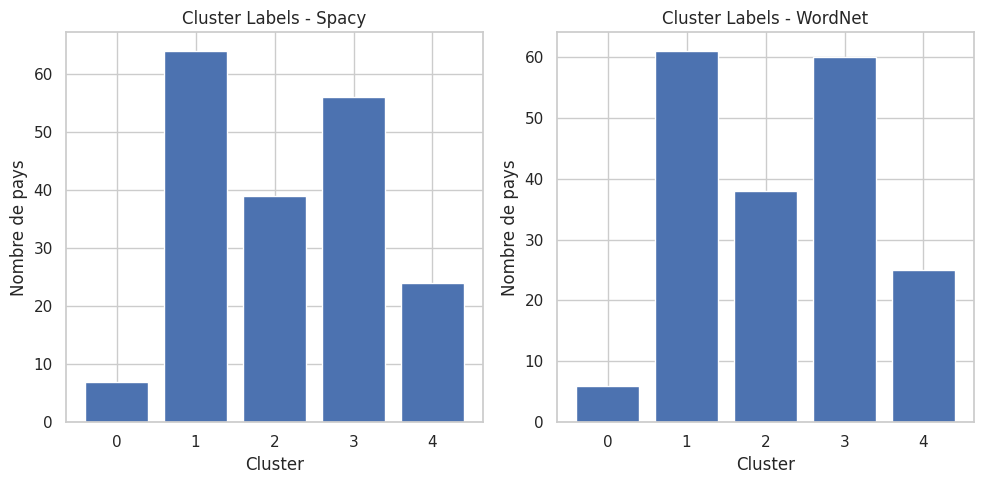

In [ ]:
import matplotlib.pyplot as plt

# Compter le nombre de pays dans chaque cluster pour Cluster_Labels_Spacy
spacy_counts = df['Cluster_Labels_Spacy'].value_counts()

# Compter le nombre de pays dans chaque cluster pour Cluster_Labels_WordNet
wordnet_counts = df['Cluster_Labels_WordNet'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Diagramme en barres pour Cluster_Labels_Spacy
ax1.bar(spacy_counts.index, spacy_counts.values)
ax1.set_title('Cluster Labels - Spacy')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Nombre de pays')

# Diagramme en barres pour Cluster_Labels_WordNet
ax2.bar(wordnet_counts.index, wordnet_counts.values)
ax2.set_title('Cluster Labels - WordNet')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Nombre de pays')

# Afficher le diagramme
plt.tight_layout()
plt.show()

Les regroupements semblent similaires entre les deux méthodes de lemmatisation, bien que l'on note de légères variations.  
**=> Nous choisissons continuer l'étude uniquement avec Spacy.**

In [ ]:
df = df.drop(['Cluster_Labels_WordNet','Anthem_cleaned_wordnet'], axis=1)

In [ ]:
from nltk import FreqDist
# FreqDist : Permet de compter la fréquence des éléments dans une liste
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
clustered_hymns_spacy = df.groupby('Cluster_Labels_Spacy')['Anthem_cleaned_spacy'].apply(list)
clustered_hymns_spacy


Cluster_Labels_Spacy
0    [country god country god worship thy name wond...
1    [azerbaijan azerbaijan glorious fatherland val...
2    [fatherland free independent century live summ...
3    [around flag stand unite one wish one goal sac...
4    [land mountains land river land field land cat...
Name: Anthem_cleaned_spacy, dtype: object

In [ ]:
clustered_countries_spacy = df.groupby('Cluster_Labels_Spacy')['Country'].apply(list)
clustered_countries_spacy

Cluster_Labels_Spacy
0    [Iceland, Brazil, Iran, Israel, Japan, Malaysi...
1    [Azerbaijan, Cyprus, Estonia, Georgia, Greece,...
2    [Armenia, Belarus, Bulgaria, Hungary, Latvia, ...
3    [Albania, Belgium, Bosnia and Herzegovina, Cro...
4    [Austria, Czechia, Finland, Ireland, Luxembour...
Name: Country, dtype: object

In [ ]:
# Concaténer tous les hymnes nationaux d'un cluster en une seule chaîne de caractères
def cluster_keywords(clustered_hymns) :
  cluster_keywords = {}
  for cluster, hymns in clustered_hymns.items():
      cluster_text = ' '.join(hymns)
      words = nltk.word_tokenize(cluster_text)
      fdist = FreqDist(words)
      cluster_keywords[cluster] = fdist.most_common(10)  # Obtenir les mots les plus fréquents
  return cluster_keywords

In [ ]:
cluster_keywords_spacy = cluster_keywords(clustered_hymns_spacy)

## PCA

In [ ]:
from sklearn.decomposition import PCA
# import matplotlib.cm as cm

In [ ]:
# PCA sur deux les premières composantes principales
def pca_spacy(df, text_vectors,):
  pca = PCA(n_components=2)
  dense_vectors = text_vectors.toarray()
  reduced_vectors = pca.fit_transform(dense_vectors)
  df_reduced = pd.DataFrame(reduced_vectors, columns=['PC1', 'PC2'])
  country_names = df['Country'].tolist()
  df_reduced['Country'] = country_names
  cluster_labels = df['Cluster_Labels_Spacy'].tolist()
  df_reduced['Cluster_Labels_Spacy'] = cluster_labels

  plt.figure(figsize=(10, 8))
  unique_labels = df_reduced['Cluster_Labels_Spacy'].unique()
  colors = plt.get_cmap('tab10', len(unique_labels))

  for i, label in enumerate(unique_labels):
    cluster_data = df_reduced[df_reduced['Cluster_Labels_Spacy'] == label]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], color=colors(i), label=label)

  plt.xlabel('PC1')
  plt.ylabel('PC2')
  plt.title('PCA')
  plt.legend()
  plt.show()

In [ ]:
import plotly.express as px

In [ ]:
# PCA sur deux les trois premières composantes principales
def pca_spacy_plotly_3PC(df, text_vectors):
    pca = PCA(n_components=3)  # Utilisation de 3 composantes principales
    dense_vectors = text_vectors.toarray()
    reduced_vectors = pca.fit_transform(dense_vectors)
    df_reduced = pd.DataFrame(reduced_vectors, columns=['PC1', 'PC2', 'PC3'])
    country_names = df['Country'].tolist()
    df_reduced['Country'] = country_names
    cluster_labels = df['Cluster_Labels_Spacy'].tolist()
    df_reduced['Cluster_Labels_Spacy'] = cluster_labels

    fig = px.scatter_3d(df_reduced, x='PC1', y='PC2', z='PC3', color='Cluster_Labels_Spacy', hover_data=['Country'])
    fig.update_layout(title='PCA')

    fig.show()


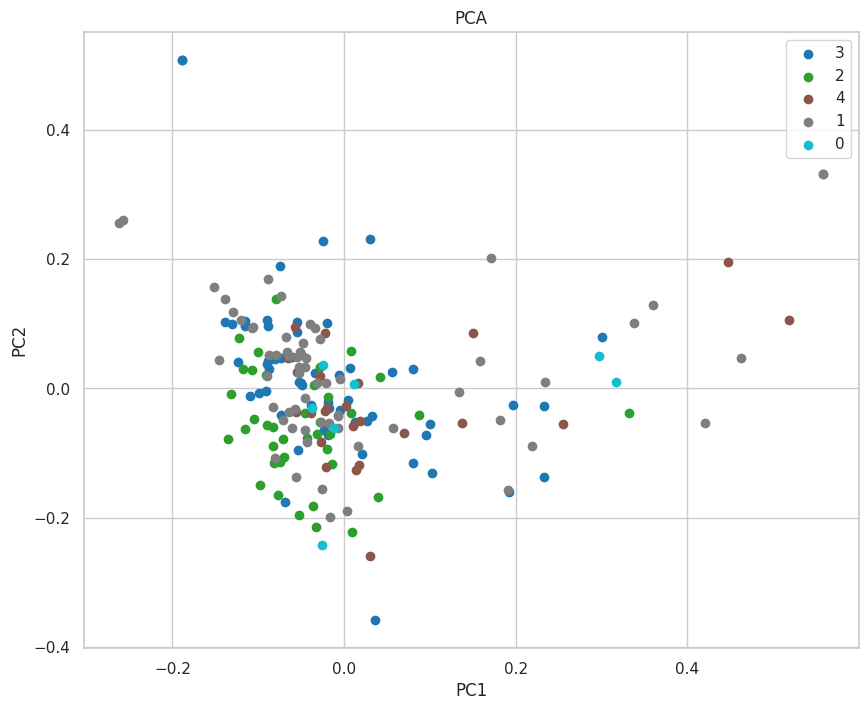

In [ ]:
pca_spacy(df, text_vectors_spacy)

In [ ]:
pca_spacy_plotly_3PC(df, text_vectors_spacy)

Nous avons réalisé deux Analyses en composantes principales.
- La première affiche les partionnements sur les deux premières composantes principales.
- La seconde sur les trois premières composantes principales, avec un axe supplémentaire offrant un graphique en trois dimensions.

Les clusters ne semblent pas bien séparés sur ces graphiques.

**=> Nous allons donc essayer de trouver un nombre de clusters optimal.**

Affichons d'abord les nuages de mots et visualisons les résultats sur une carte.

## WordCloud

In [ ]:
def barplot_word_freq_barplot(data):
  num_plots = len(data)
  fig, axes = plt.subplots(num_plots, figsize=(6, 4*num_plots))

  for i, (key, value) in enumerate(data.items()):
      sorted_values = sorted(value, key=lambda x: x[1], reverse=True)
      names, frequencies = zip(*sorted_values)

      axes[i].barh(range(len(names)), frequencies)
      axes[i].set_yticks(range(len(names)))
      axes[i].set_yticklabels(names)
      axes[i].set_title(f'Cluster {key} Fréquence')
      axes[i].set_xlabel('Fréquence')
      axes[i].invert_yaxis()

  plt.tight_layout()
  plt.show()

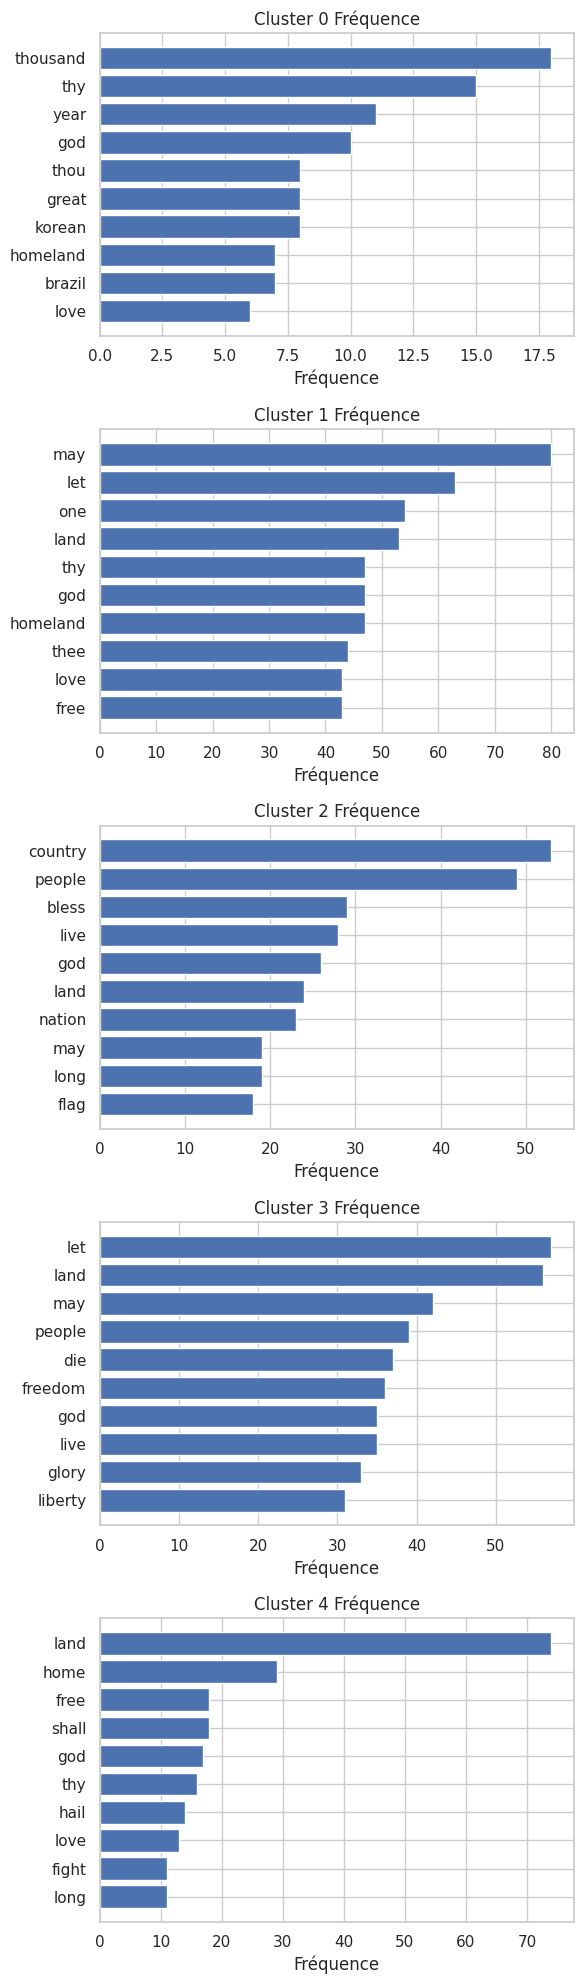

In [ ]:
barplot_word_freq_barplot(cluster_keywords_spacy)

In [ ]:
from wordcloud import WordCloud

In [ ]:
import numpy as np

def display_wordcloud(cluster_keywords, clustered_countries):
    for i in range(len(cluster_keywords)):
        wordcloud = WordCloud(background_color="white")

        wordcloud.generate_from_frequencies(dict(cluster_keywords[i]))

        plt.figure(figsize=(10, 4))

        # Afficher le nuage de mots à gauche
        plt.subplot(1, 2, 1)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f'Cluster {i}', fontsize=20)

        # Afficher les pays à droite
        plt.subplot(1, 2, 2)
        plt.axis("off")
        countries = clustered_countries[i]
        num_countries = len(countries)
        half_num_countries = int(np.ceil(num_countries / 2))

        countries_text_left = '\n'.join(countries[:half_num_countries])
        countries_text_right = '\n'.join(countries[half_num_countries:])

        plt.text(0, 1, countries_text_left, fontsize=10, verticalalignment='top')
        plt.text(0.5, 1, countries_text_right, fontsize=10, verticalalignment='top')
        plt.title('Pays', fontsize=16)

        plt.tight_layout()
        plt.show()

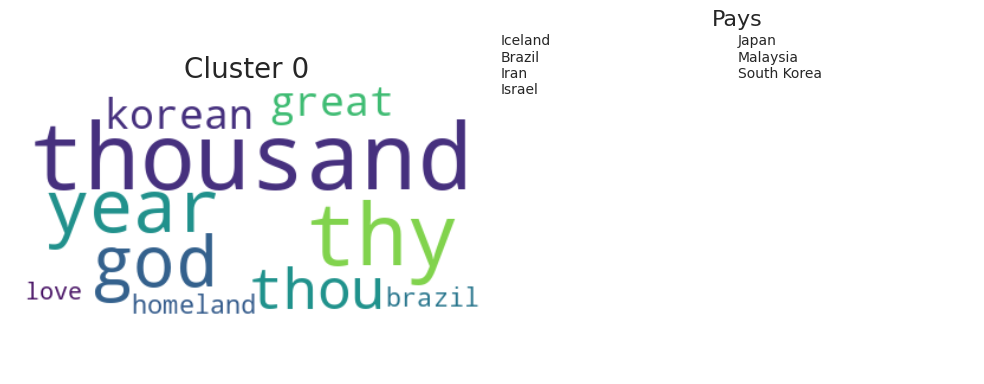

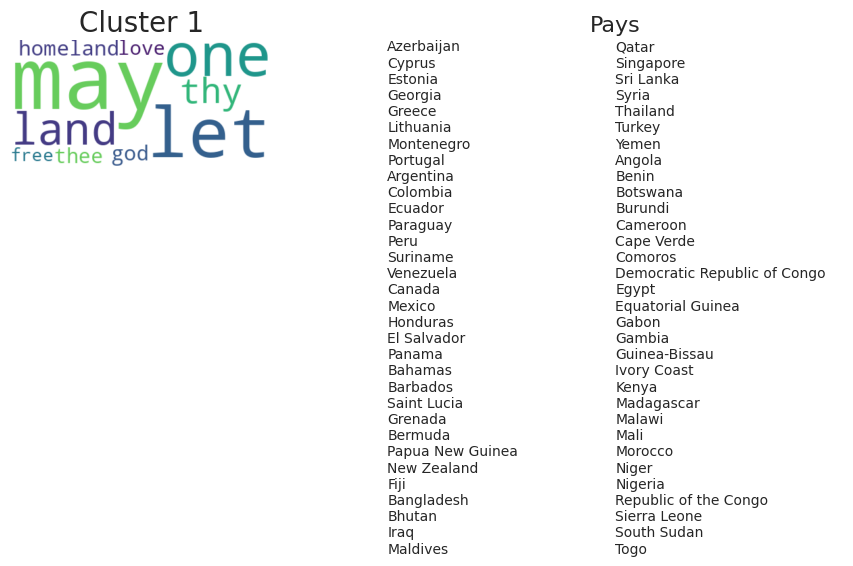

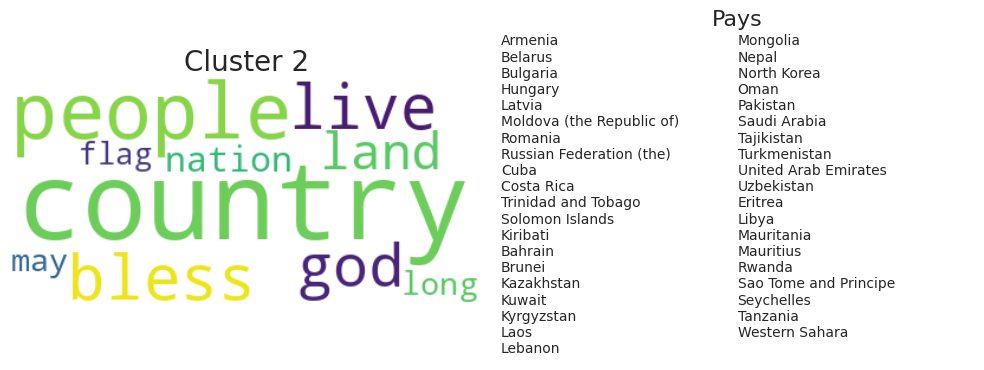

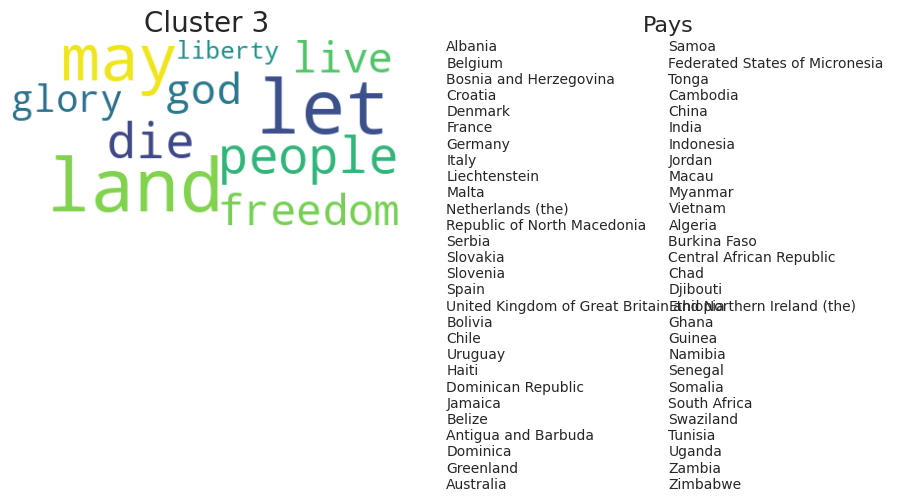

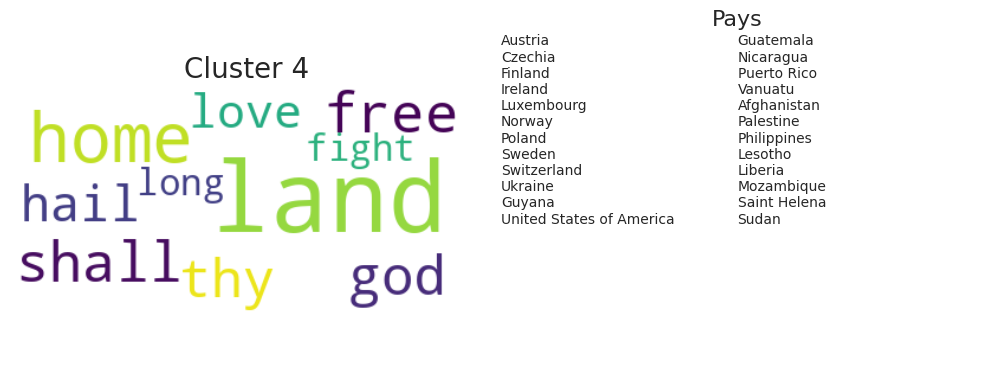

In [ ]:
display_wordcloud(cluster_keywords_spacy,clustered_countries_spacy)

## Carte

In [ ]:
 !pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Trouver une carte avec correspondance pour tout les pays du dataset (ou exclures les pays manquant de l'affichage).

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
# Charger le shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [ ]:
# Comparer les listes de codes.
diff = list(set(df['Alpha-3']) - set(world['iso_a3']))
print(len(diff), diff)

df_filtered = df.query("`Alpha-3` in @diff")

22 ['BHR', 'DMA', 'SYC', 'LIE', 'FSM', 'GRD', 'STP', 'ATG', 'MLT', 'KIR', 'BRB', 'LCA', 'WSM', 'MUS', 'MAC', 'TON', 'COM', 'MDV', 'CPV', 'SHN', 'BMU', 'SGP']


Les pays non présents dans cette liste sont essentiellement des iles.
Pour une première itération on ne les affichera pas.


In [ ]:
import textwrap

In [ ]:
def merged_for_map(data,world,cluster_keywords):
  merged_data = world.merge(data, left_on='iso_a3', right_on='Alpha-3')

  # Convertir la colonne pour que plotly la considère comme catégorielle
  merged_data['Cluster_Labels_Spacy'] = merged_data['Cluster_Labels_Spacy'].astype('category')

  #Tooltip
  # Création de la colonne 'top_words_spacy' dans le dataframe
  merged_data['top_words_spacy'] = merged_data['Cluster_Labels_Spacy'].apply(lambda x: ', '.join([word for word, count in cluster_keywords.get(x, [])]))

  return merged_data

In [ ]:
merged_data = merged_for_map(df,world,cluster_keywords_spacy)
merged_data.head()

pop_est      continent                      name iso_a3  gdp_md_est  \
0     889953.0        Oceania                      Fiji    FJI        5496   
1   58005463.0         Africa                  Tanzania    TZA       63177   
2     603253.0         Africa                 W. Sahara    ESH         907   
3   37589262.0  North America                    Canada    CAN     1736425   
4  328239523.0  North America  United States of America    USA    21433226   

                                            geometry  \
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

                    Country Alpha-3      Continent  \
0                      Fiji     FJI        Oceania   
1                  Tanzania     TZA         Africa   
2            Western Sahara     ESH         Africa   
3                    Canada     CAN  North_America   
4  United States of America     USA  North_America   

                                              Anthem  \
0  Blessing grant oh God of nations on the isles ...   
1  God bless Africa Bless its leaders Wisdom, uni...   
2  O sons of the Sahara! In the battlefield, you ...   
3  O Canada! Our home and native land! True patri...   
4  Oh, say can you see by the dawn's early light ...   

                                Anthem_cleaned_spacy Cluster_Labels_Spacy  \
0  blessing grant god nation isle fiji stand unit...                    1   
1  god bless africa bless leader wisdom unity pea...                    2   
2  son sahara battlefield torch holder long road ...                    2   
3  canada home native land true patriot love thou...                    1   
4  say see dawn early light proudly hail twilight...                    4   

                                     top_words_spacy  
0  may, let, one, land, thy, god, homeland, thee,...  
1  country, people, bless, live, god, land, natio...  
2  country, people, bless, live, god, land, natio...  
3  may, let, one, land, thy, god, homeland, thee,...  
4  land, home, free, shall, god, thy, hail, love,...

In [ ]:
import plotly.express as px

In [ ]:
def map_choropleth(df, clusters, hover_data, title):
  # Choropleth
  fig = px.choropleth(
      df,
      locations="iso_a3",
      color=clusters,
      hover_data=["Country", hover_data],
      projection="natural earth"
  )

  fig.update_layout(
      title=title,
      geo=dict(showcoastlines=True, showcountries=True),
      width=800,
  )

  # Afficher la carte
  fig.show()

In [ ]:
map_choropleth(merged_data,'Cluster_Labels_Spacy','top_words_spacy','Clusters par pays')

On observe ici la première tentative de partionnement avec seulement 5 clusters.

Avant d'effectuer une interprétration plus précise, nous allons tenter de trouver de meilleurs paramètres.

# KMeans : 2nd itération avec recherche du nombre de clusteurs optimaux

Nous allons utiliser les méthodes du coude et silhouette pour tenter de déterminer un nombre plus optimal de clusters pour obtenir une séparation efficace.

In [ ]:
from sklearn.metrics import silhouette_score

## k_values

In [ ]:
  # Nombre de valeurs de k à tester
  k_values = range(1, 20)

Il existe plusieurs façons d'initialiser les centroïdes dans l'algorithme KMeans. L'initialisation est importante car elle peut influencer le résultat final de l'algorithme, notamment dans les cas où l'algorithme ne parvient pas à sortir d'un minimum local.

- init='k-means++' : C'est la méthode d'initialisation par défaut et elle est généralement préférée car elle peut conduire à des résultats plus cohérents par rapport à une initialisation aléatoire. La méthode 'k-means++' choisit les centres de cluster initiaux de manière à accélérer la convergence de l'algorithme. Elle choisit d'abord un centre de manière aléatoire, puis les centres suivants sont choisis parmi les points de données restants avec une probabilité proportionnelle à leur distance carrée au point le plus proche qui a déjà été choisi comme centre. Cette méthode tend à répartir les centres initiaux de manière à les éloigner les uns des autres et des limites de l'espace de données.

- init='random' : Cette méthode choisit k observations (lignes) au hasard à partir des données pour les centres initiaux.
- init='ndarray' : Vous pouvez passer un ndarray (une matrice) où chaque ligne est un centre initial.

Il est à noter que n_init, qui spécifie le nombre de fois que l'algorithme sera exécuté avec des centroïdes initiaux différents, fonctionne en tandem avec init. L'algorithme renverra le meilleur résultat (basé sur l'inertie) de ces exécutions multiples.

In [ ]:
def kmeans_range(text_vectors,k_values):
  inertia_values = []
  silhouette_values = []
  for k in k_values:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, tol = 0.0001, random_state = 42).fit(text_vectors)
    inertia_values.append(kmeans.inertia_)
    if k > 1:
      silhouette_values.append(silhouette_score(text_vectors, kmeans.labels_))
  return inertia_values, silhouette_values

In [ ]:
inertia_values, silhouette_values = kmeans_range(text_vectors_spacy,k_values)

In [ ]:
def plot_coude(k_values, inertia_values):
  plt.plot(k_values, inertia_values, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Inertie')
  plt.title('Méthode du coude pour la recherche du k optimal')
  plt.xticks(np.arange(min(k_values), max(k_values)+1, 1.0))
  plt.show()

In [ ]:
def plot_silhouette(k_values, silhouette_values):
  plt.plot(k_values[1:], silhouette_values, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Silhouette Score')
  plt.title('Méthode Silhouette pour la recherche du k optimal')
  plt.xticks(np.arange(min(k_values[1:]), max(k_values)+1, 1.0))
  plt.show()

## Méthode du coude

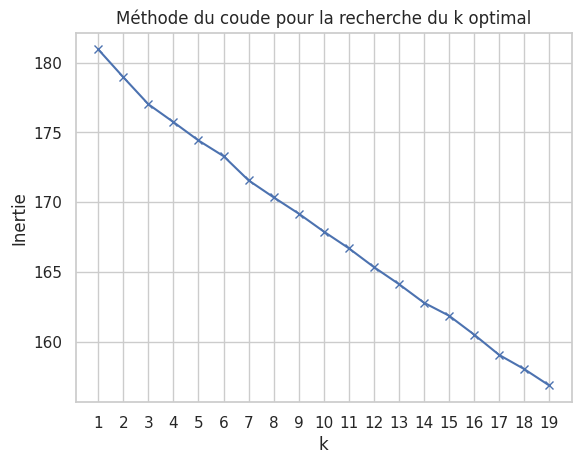

In [ ]:
plot_coude(k_values,inertia_values)

La méthode du coude est une technique utilisée pour déterminer le nombre optimal de clusters dans un modèle de partitionnement.  

On trace un graphique montrant l'inertie (ou la somme des carrés à l'intérieur des clusters) en fonction du nombre de clusters.

Dans une situation idéale, le graphique ressemblerait à un bras, avec un "coude" distinct où l'inertie cesse de diminuer aussi rapidement.

**=> Ici il n'y a aucune variation.**

## Méthode Silhouette

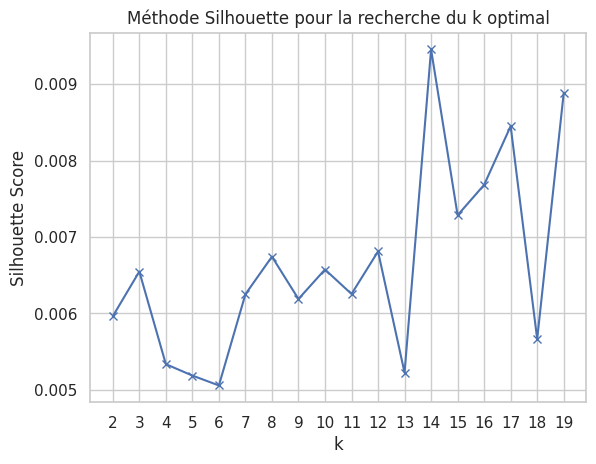

In [ ]:
plot_silhouette(k_values,silhouette_values)

In [ ]:
silhouette_values

[0.005963724943977035,
 0.006548471097846032,
 0.005337130219164881,
 0.005187892805190394,
 0.005058609745684609,
 0.006251460495562772,
 0.006743111772725467,
 0.006189413286786999,
 0.006574970602163591,
 0.006254853158527994,
 0.0068112279424163945,
 0.005226198234160898,
 0.009452724676007829,
 0.0072850803692304025,
 0.007682068657214157,
 0.008449832577747111,
 0.005664488860574208,
 0.00888227889508032]

Le score de la silhouette est une mesure utilisée pour déterminer le degré de séparation entre les clusters. Il peut varier de -1 à +1.

Ici, La méthode silhouète affiche des variations mais les valeurs sont très proches de zéro.

Ce qui suggère que les clusters se chevauchent beaucoup et que les points ne sont pas clairement attribués à un cluster spécifique.

**=> Cela pourrait signifier que le partitionnement par K-means n'est pas très efficace pour ces données, ou que le nombre de clusters choisi n'est pas optimal.**


# KMeans : 3ième itération avec modification du pré-traitement.

## Résultats de la première itération
Les deux préprocesseurs avec wordnet et spacy étaient prochent à plus de 80%.

Voici les résultats obtenus pour spacy :

{0: [('thousand', 18),
  ('thy', 15),
  ('year', 11),
  ('god', 10),
  ('thou', 8),
  ('great', 8),
  ('korean', 8),
  ('homeland', 7),
  ('brazil', 7),
  ('iceland', 6)],
 1: [('may', 76),
  ('let', 65),
  ('one', 53),
  ('thy', 49),
  ('land', 49),
  ('god', 45),
  ('nation', 41),
  ('shall', 40),
  ('ever', 39),
  ('freedom', 38)],
 2: [('people', 55),
  ('country', 54),
  ('land', 25),
  ('nation', 21),
  ('live', 21),
  ('glory', 19),
  ('god', 19),
  ('flag', 18),
  ('one', 18),
  ('world', 18)],
 3: [('land', 57),
  ('let', 55),
  ('may', 50),
  ('god', 45),
  ('people', 36),
  ('freedom', 34),
  ('free', 33),
  ('glory', 32),
  ('flag', 30),
  ('one', 30)],
 4: [('land', 76),
  ('home', 30),
  ('free', 20),
  ('canada', 20),
  ('homeland', 19),
  ('thy', 19),
  ('shall', 18),
  ('god', 16),
  ('thee', 15),
  ('thou', 13)]}

On peut choisir de retirer les évocations de pays qui ne devraient pas aider à créer des clusters :
- iceland
- brazil
- korean
- canada

De plus cela attire l'attention sur le fait que ces noms de pays apparaissent fréquement alors qu'il ne doivent concerner que les pays considérés. Ces mots doivent être répétés plusieurs fois dans l'hymne.
- **Il parait intéressant de retirer tous les doublons de chaque hymne.**

Cette approche peut faire perdre un peu de sens à certains hymnes car la répétition d'un mot signifie qu'un pays lui donne de l'importance, justement par exemple si il est choisi pour le refrain. Cependant les hymnes étants des chants, la répétition peu également être essentiellement artisitique et nuire à la recherche de corrélations entre les pays.

## Pré-traitements

#### Stopwords personnalisés

In [ ]:
# Classe qui hérite de la classe précédente.
# permet de définir des stop words personnalisés
# et de supprimer les doublons.
class CustomTextPreprocessor(TextPreprocessorSpacy):
    def __init__(self, additional_stopwords):
        super().__init__()
        self.stopwords = self.stopwords.union(set(additional_stopwords))

    def preprocess(self, text):
        processed_text = super().preprocess(text)

        # Supprimer les doublons
        tokens = processed_text.split()
        processed_text = ' '.join(list(set(tokens)))

        return processed_text


In [ ]:
# Déclaration
additional_stopwords = ['iceland','korean','brazil','canada']
custom_preprocessor = CustomTextPreprocessor(additional_stopwords=additional_stopwords)

In [ ]:
# Appliquer le prétraitement des textes sur la colonne "Anthem"
df['Anthem_cleaned_spacy'] = df['Anthem'].apply(custom_preprocessor.preprocess) # 3ième itération

In [ ]:
# Vectorisation
text_vectors_spacy = vectorizer.fit_transform(df['Anthem_cleaned_spacy'])
tfidf_spacy = pd.DataFrame(text_vectors_spacy.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_spacy.head()

4th  abandon  abanyarwanda  abide  ablaze  able  abound  absolute  abstain  \
0  0.0      0.0           0.0    0.0     0.0   0.0     0.0       0.0  0.19204   
1  0.0      0.0           0.0    0.0     0.0   0.0     0.0       0.0  0.00000   
2  0.0      0.0           0.0    0.0     0.0   0.0     0.0       0.0  0.00000   
3  0.0      0.0           0.0    0.0     0.0   0.0     0.0       0.0  0.00000   
4  0.0      0.0           0.0    0.0     0.0   0.0     0.0       0.0  0.00000   

   abundance  ...  zeal  zealand  zealous  zenith  zimbabwe  zion  ºciuszko  \
0        0.0  ...   0.0      0.0      0.0     0.0       0.0   0.0       0.0   
1        0.0  ...   0.0      0.0      0.0     0.0       0.0   0.0       0.0   
2        0.0  ...   0.0      0.0      0.0     0.0       0.0   0.0       0.0   
3        0.0  ...   0.0      0.0      0.0     0.0       0.0   0.0       0.0   
4        0.0  ...   0.0      0.0      0.0     0.0       0.0   0.0       0.0   

   ãƒâ     œende  šawice  
0  0.0  0.000000     0.0  
1  0.0  0.000000     0.0  
2  0.0  0.000000     0.0  
3  0.0  0.200369     0.0  
4  0.0  0.000000     0.0  

[5 rows x 2973 columns]

<a name="analyse"></a>
# Comparaison des prétraitements et analyse

In [ ]:
# Appliquer l'algorithme de partitionnement avec K-means exemple avec 5 clusters
def part_kmeans_n_cluster_selected(text_vectors):
  kmeans = KMeans(n_clusters=5, n_init='auto', random_state=42)
  kmeans.fit(text_vectors)
  # Obtenir les labels de partitionnement
  labels = kmeans.labels_
  return labels

In [ ]:
clustered_hymns_spacy = df.groupby('Cluster_Labels_Spacy')['Anthem_cleaned_spacy'].apply(list)
clustered_countries_spacy = df.groupby('Cluster_Labels_Spacy')['Country'].apply(list)
cluster_keywords_spacy = cluster_keywords(clustered_hymns_spacy)

In [ ]:
labels_spacy = part_kmeans_n_cluster_selected(tfidf_spacy)
df['Cluster_Labels_Spacy'] = labels_spacy
merged_data_2 = merged_for_map(df,world,cluster_keywords_spacy)

In [ ]:
map_choropleth(merged_data,'Cluster_Labels_Spacy','top_words_spacy','Clusters par pays - 1ière itération sans prétraitements.')

In [ ]:
map_choropleth(merged_data_2,'Cluster_Labels_Spacy','top_words_spacy','Clusters par pays - 3ième itération avec suppression des doublons.')

En modifiant le prétraitement pour supprimer les doublons on s'apperçoit que le partionnement pour le même nombre de clusters que lors de la première itération parait avoir déjà plus de sens.
Par exemple :
- Le cluster 2 semble contenir plusieurs pays ayant eut une influence Britanique.
- Le cluster 3 contient un certain nombre de républiques.
- Le cluster 4 contient nombre de pays ayant eut une influence des Etats-unis.



On peut alors observer les termes les plus fréquents par clusters :

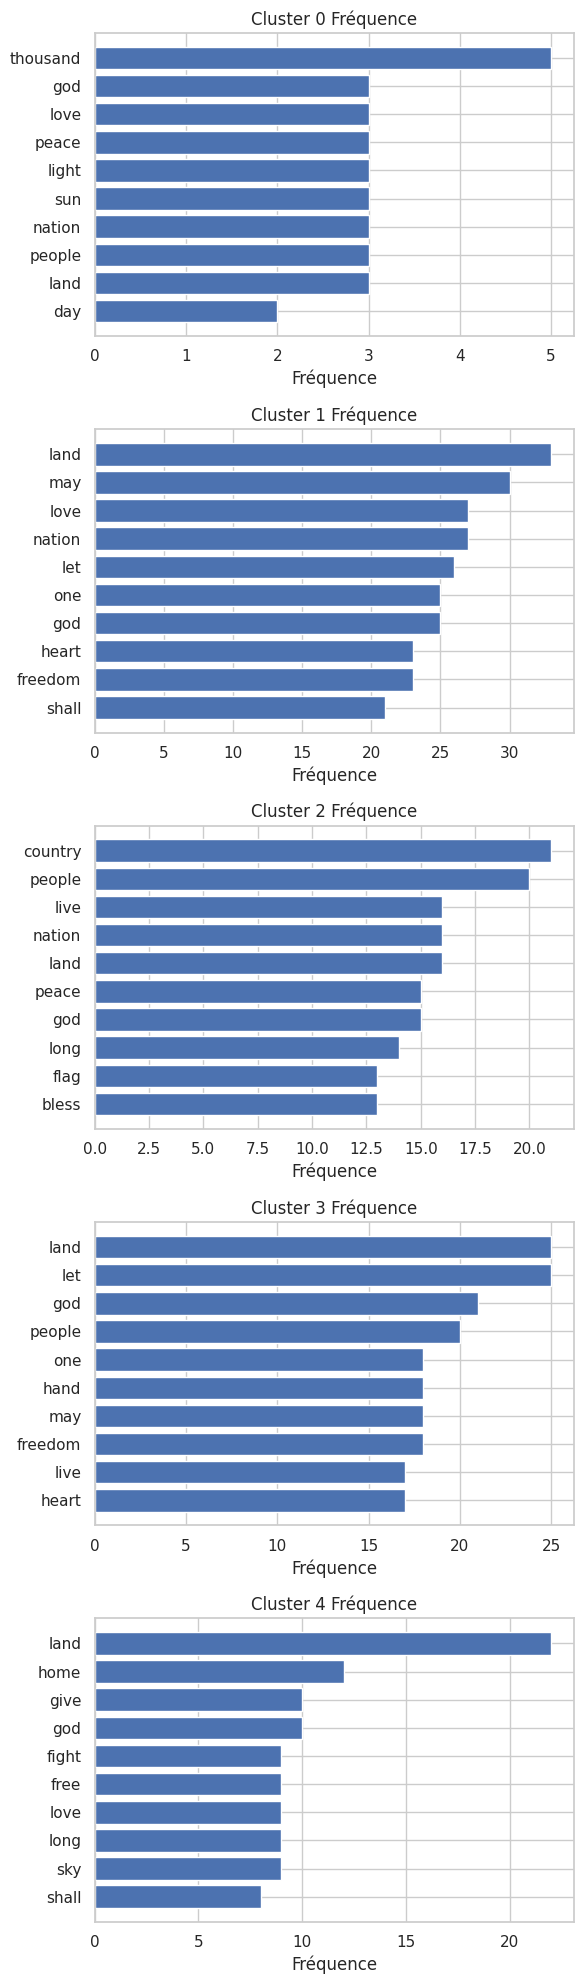

In [ ]:
barplot_word_freq_barplot(cluster_keywords_spacy)

## Thématiques par clusters

On en en déduire les thématiques suivantes :
- Cluster 0 : **"Spiritualité et Prospérité"**
 - Ce cluster met en évidence un fort accent sur l'espoir (lumière, soleil), l'amour et la spiritualité (Dieu).
 - Le thème de la nation et du peuple est également présent, ainsi que le concept de paix.

- Cluster 1 : **"Dévotion patriotique "**
  - Les mots-clés de ce cluster évoquent le sentiment d'appartenance à une nation, l'amour du pays (terre, nation), l'aspiration à la liberté, la volonté (let), et l'importance de l'individu (un).
  -  L'aspect spirituel est également présent avec la référence à Dieu.

- Cluster 2 : **"Longévité de la patrie "**
  - Le mot 'long' dans ce cluster pourrait suggérer un désir de longévité ou de continuité pour la nation
  - De plus, l'appel à la bénédiction de Dieu indique un élément de spiritualité.
  - Mais les mots les plus importants sont 'people', 'country', et 'land' qui suggèrent une forte orientation vers la communauté et la patrie.

- Cluster 3 : **"Solidarité patriotique"**
 - Avec un accent plus fort sur les mots 'land', 'let', et 'people', ce cluster pourrait indiquer un thème de solidarité.
 - 'god' évoque à nouveau la spiritualité.
 -  'Land' et 'people' insistent sur l'importance de la communauté et de la patrie.

- Cluster 4 : **"Lutte pour la Terre"**
 - Le mot 'land' étant extrêmement fréquent, ainsi que 'home', ce cluster pourrait suggérer un thème d'attachement fort à la terre natale.
 - Fight' et 'love' suggèrent une volonté de se battre pour ce qui est aimé

## Présentation sous forme de nuages de mots

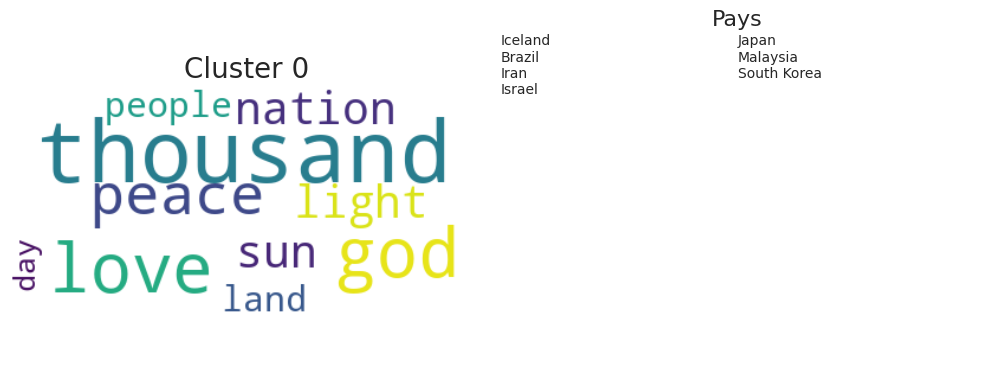

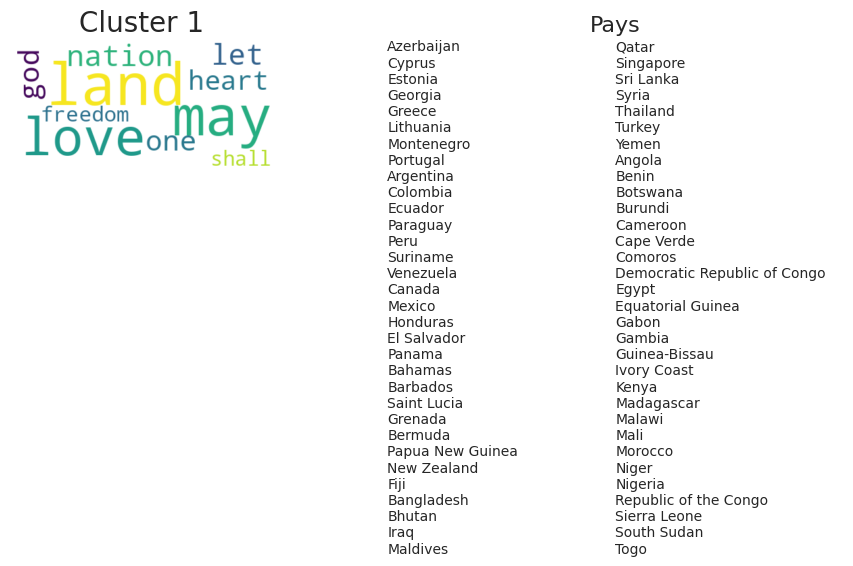

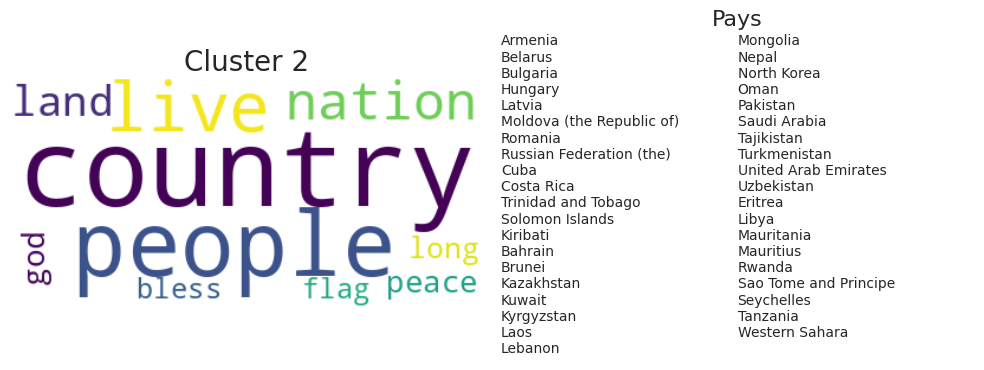

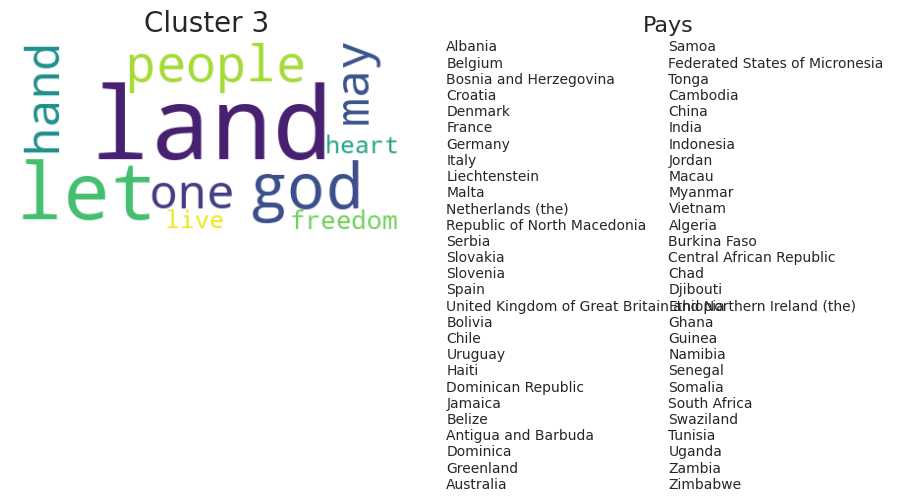

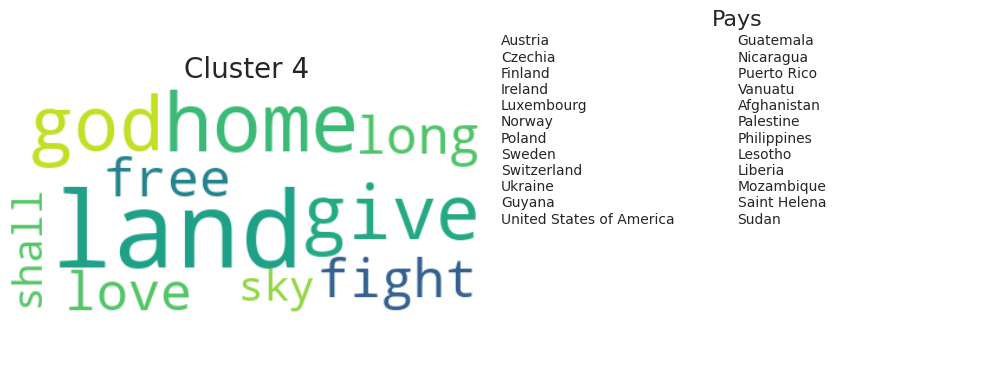

In [ ]:
display_wordcloud(cluster_keywords_spacy,clustered_countries_spacy)

---

# Recherche du nombre de clusters optimaux.

## Méthode du coude

In [ ]:
inertia_values_spacy, silhouette_values_spacy = kmeans_range(tfidf_spacy,k_values)

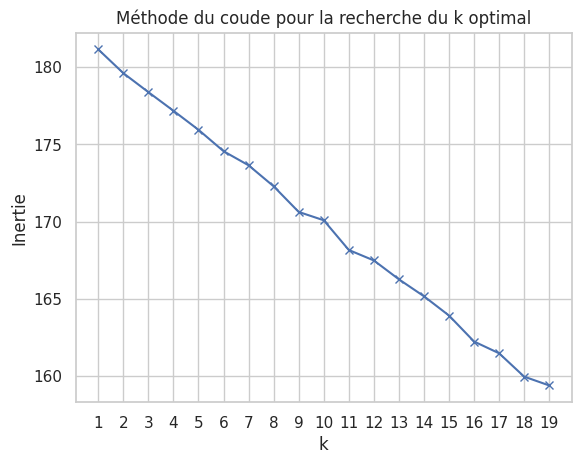

In [ ]:
plot_coude(k_values,inertia_values_spacy)

## Méthode Silhouette

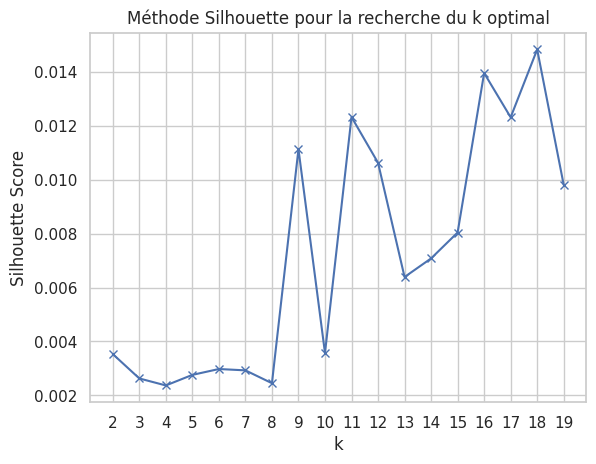

In [ ]:
plot_silhouette(k_values,silhouette_values_spacy)

L'allure de la courbe en coude ne laisse toujours pas apparaitre de partionnement significatif.
La méthode silhouette a toujours des scores faibles. On remarque tout de même des paliers d'amélioration pour 9, 11 et 16 clusters.

**=> On tente d'explorer l'efficaciter du partionnement pour 14 clusters.**

In [ ]:
# Appliquer l'algorithme de partitionnement avec K-means
def part_kmeans_n_cluster_selected(text_vectors):
  kmeans = KMeans(n_clusters=16, n_init='auto', random_state=42)
  kmeans.fit(text_vectors)
  # Obtenir les labels de partitionnement
  labels = kmeans.labels_
  return labels

In [ ]:
labels_spacy = part_kmeans_n_cluster_selected(tfidf_spacy)
df['Cluster_Labels_Spacy'] = labels_spacy
df.head(2)

Country Alpha-3 Continent  \
0  Albania     ALB    Europe   
1  Armenia     ARM    Europe   

                                              Anthem  \
0  Around our flag we stand united, With one wish...   
1  Our Fatherland, free, independent, That has fo...   

                                Anthem_cleaned_spacy  Cluster_Labels_Spacy  
0  swear oath place die cause wish thrive weapon ...                     9  
1  brother shine die summon forever bathe son tri...                     5

## PCA

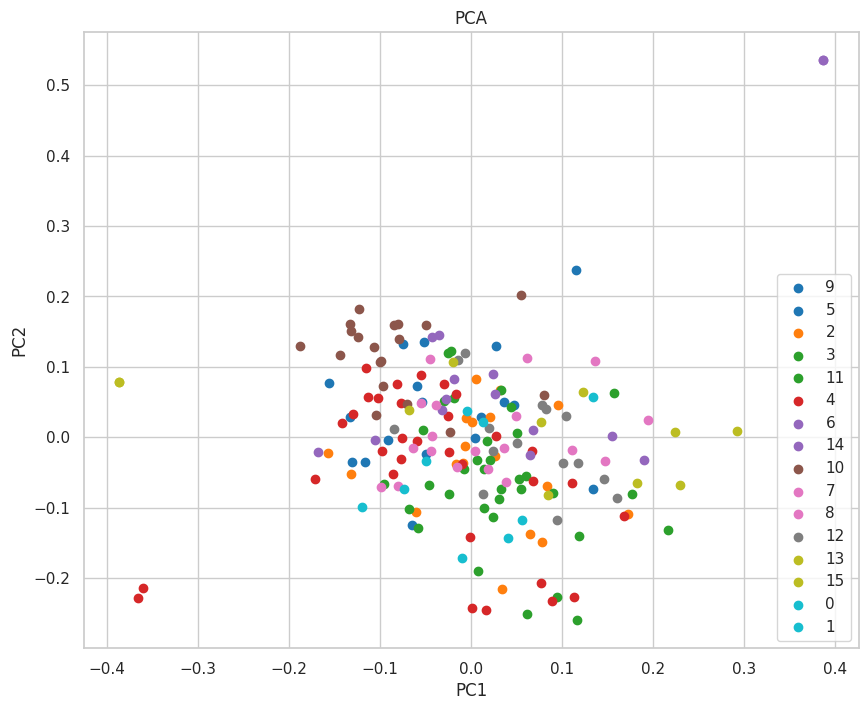

In [ ]:
pca_spacy(df, text_vectors_spacy)

In [ ]:
pca_spacy_plotly_3PC(df, text_vectors_spacy)

## WordCLoud

In [ ]:
clustered_hymns_spacy = df.groupby('Cluster_Labels_Spacy')['Anthem_cleaned_spacy'].apply(list)
clustered_countries_spacy = df.groupby('Cluster_Labels_Spacy')['Country'].apply(list)
cluster_keywords_spacy = cluster_keywords(clustered_hymns_spacy)

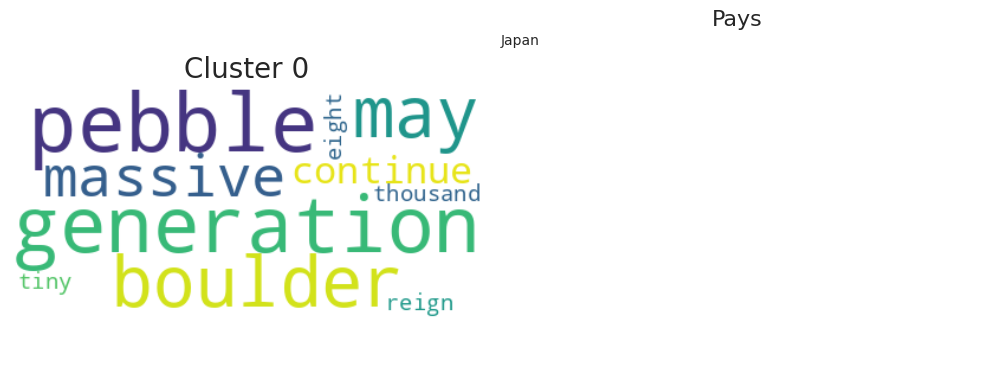

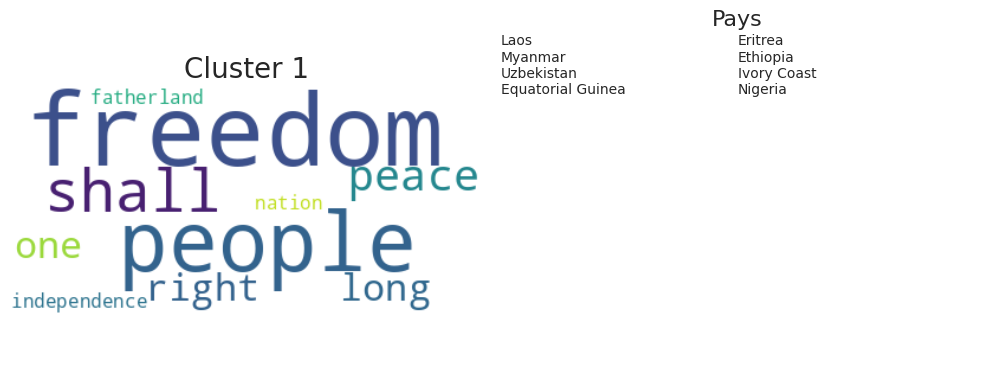

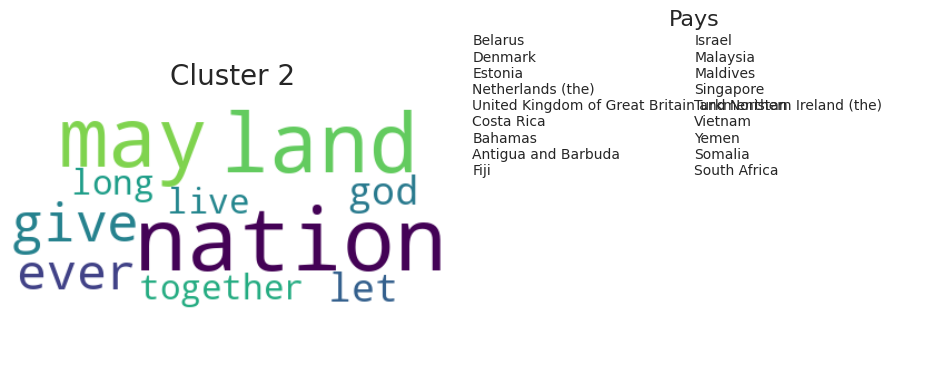

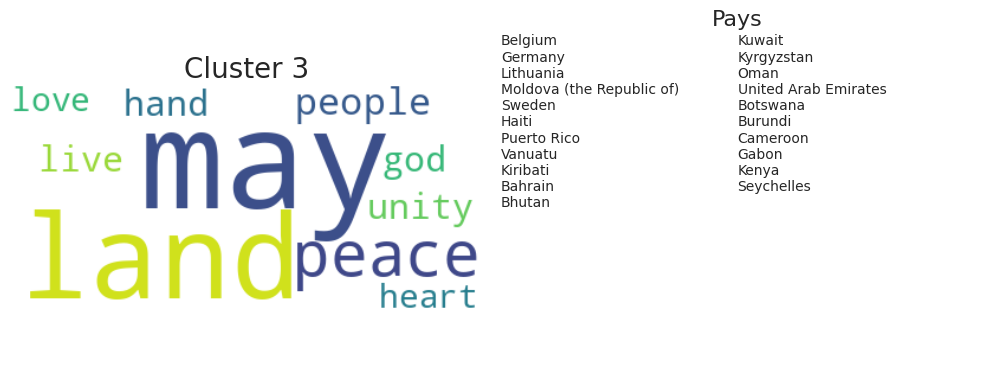

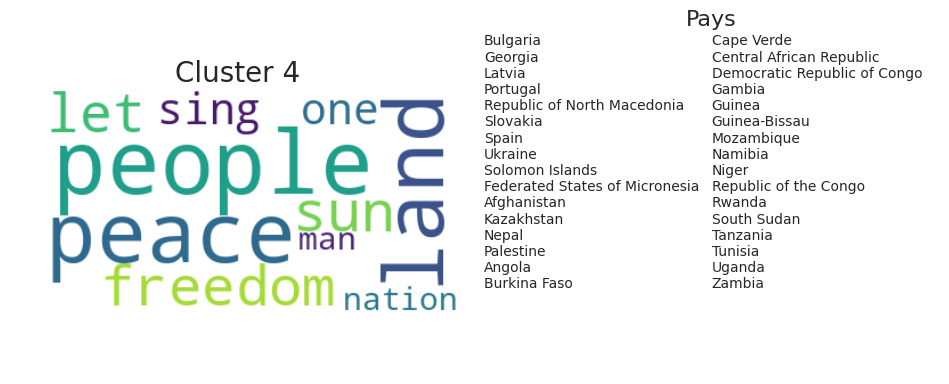

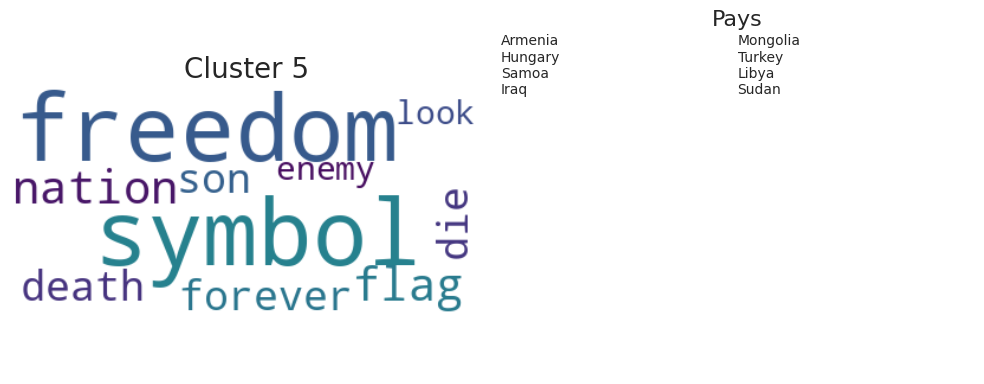

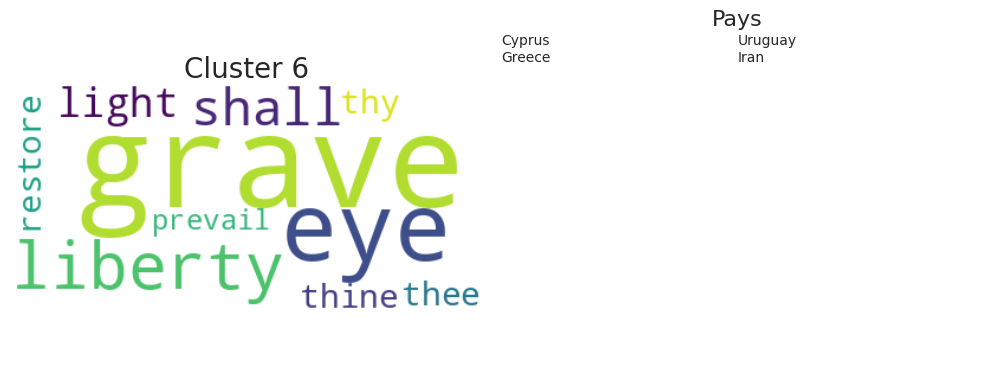

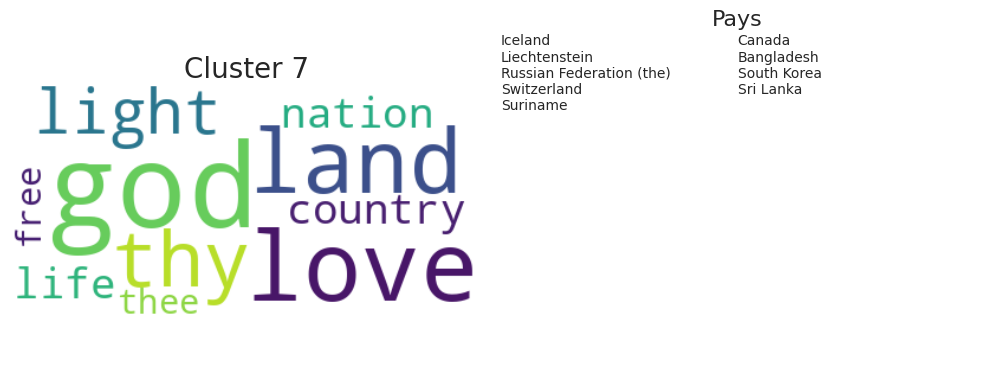

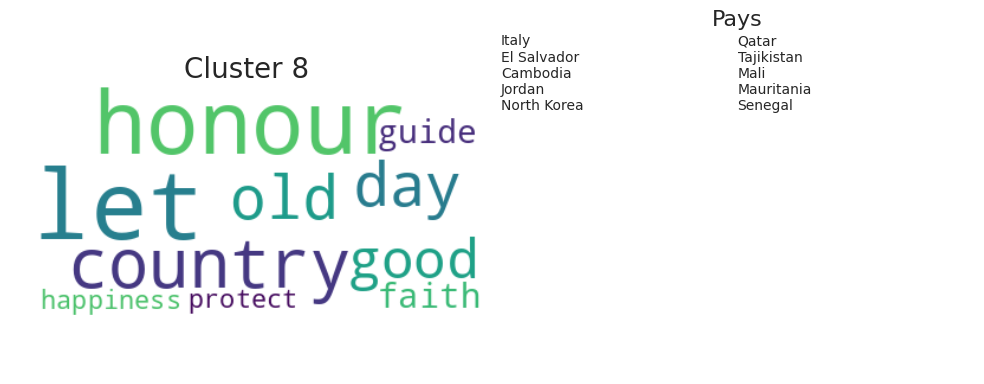

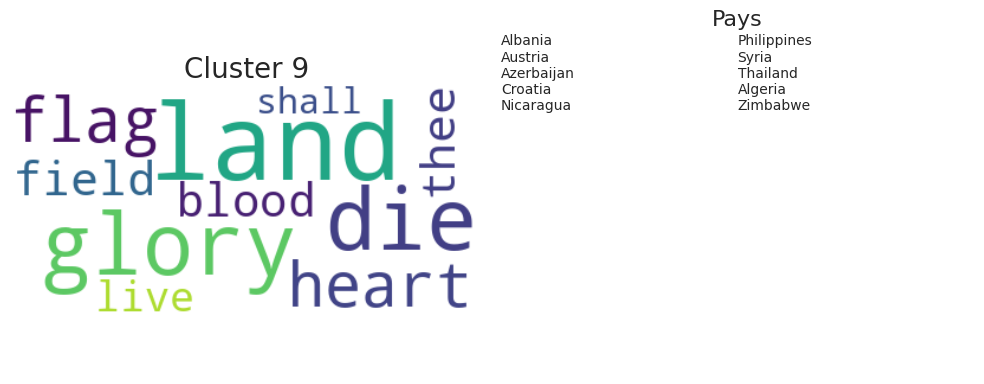

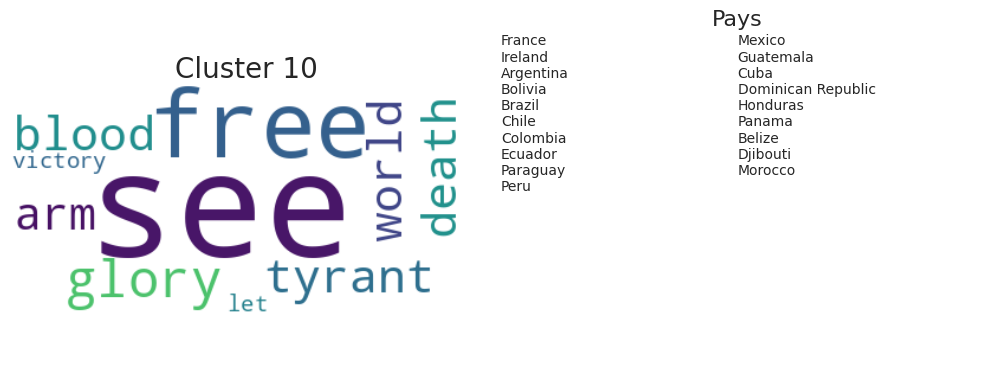

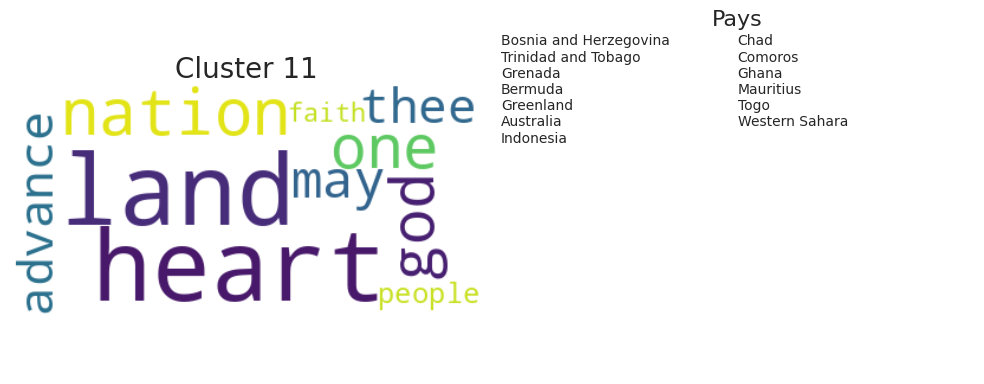

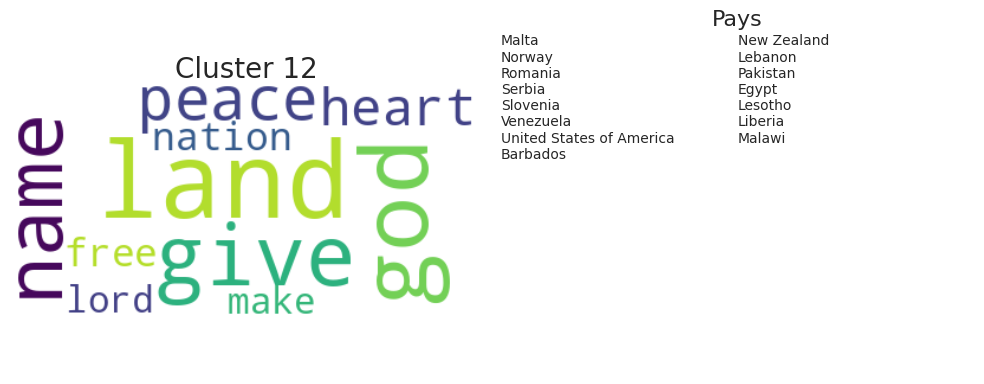

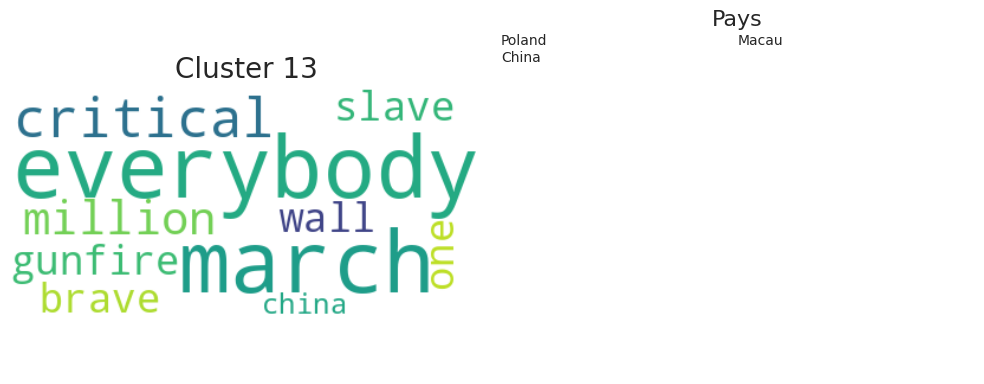

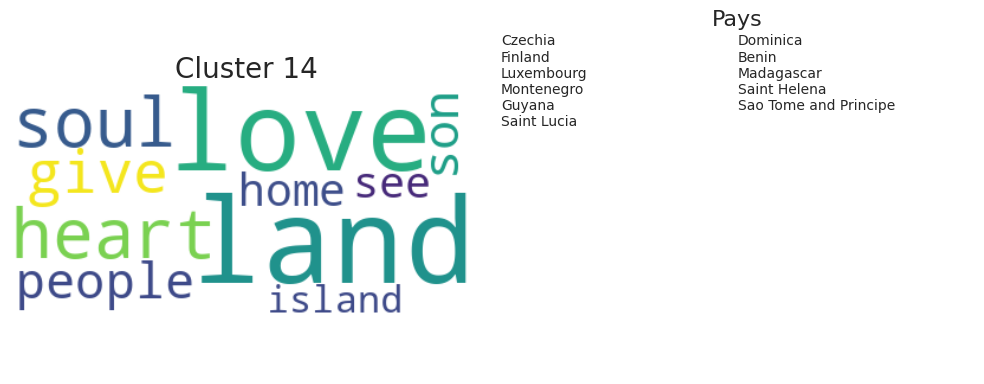

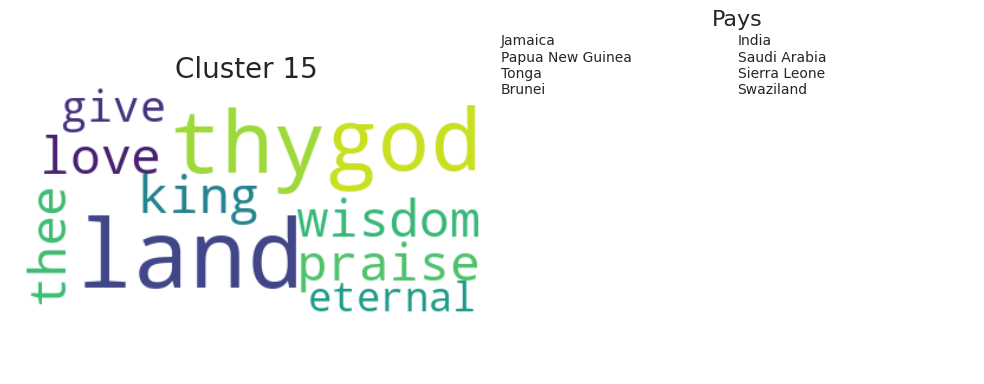

In [ ]:
 display_wordcloud(cluster_keywords_spacy,clustered_countries_spacy)

## Carte

In [ ]:
merged_data = merged_for_map(df,world,cluster_keywords_spacy)

In [ ]:
map_choropleth(merged_data,'Cluster_Labels_Spacy','top_words_spacy','Clusters par pays - Kmeans 13 clusters')

## Conclusion

Avec 14 clusters :
Malgré l'application des méthodes du coude et de la silhouette, nous n'observons pas de variation significative permettant de déterminer un nombre optimal de clusters.

En effet, les scores de la méthode silhouette restent particulièrement faibles, indiquant un chevauchement considérable des clusters.

De plus, augmenter le nombre de clusters jusqu'à 14 rend l'interprétation des nuages de mots et de la carte géographique plus complexe.

**Nous en concluons donc que la recherche d'un nombre optimal de clusters, dans ce contexte, n'a pas abouti à des résultats décisifs.**

Il semble dès lors plus approprié d'adopter une approche guidée par l'objectif métier pour déterminer le nombre de clusters.

En l'occurrence, le choix de **5 clusters** permettra une analyse efficace et compréhensible.

**=> Ainsi, nous pouvons conserver l'analyse effectuée à l'étape précédente.**  
[Retourner à l'analyse](#analyse)

# **Partitionnement Hiérarchique**

Nous souhaitons explorer le partitionnement hiérarchique pour obtenir une perspective différente de notre jeu de données. Le partitionnement hiérarchique peut révéler des structures de clusters plus complexes et des relations hiérarchiques entre les observations.
Contrairement au partitionnement K-means, qui attribue chaque observation à un cluster spécifique, le partitionnement hiérarchique construit une structure de clusters en forme d'arbre, appelée dendrogramme. Cette approche permet de capturer des relations de similarité à différentes échelles, allant des clusters les plus larges aux clusters les plus fins.

In [ ]:
# Appliquer le prétraitement des textes sur la colonne "Anthem"
df['Anthem_cleaned_wordnet'] = df['Anthem'].apply(preprocessor_wordnet.preprocess)
df['Anthem_cleaned_spacy'] = df['Anthem'].apply(preprocessor_spacy.preprocess)

In [ ]:
# Vectorisation des textes
vectorizer = TfidfVectorizer()
text_vectors_spacy = vectorizer.fit_transform(df['Anthem_cleaned_spacy'])
tfidf_spacy = pd.DataFrame(text_vectors_spacy.toarray(), columns=vectorizer.get_feature_names_out())
text_vectors_wordnet = vectorizer.fit_transform(df['Anthem_cleaned_wordnet'])
tfidf_wordnet = pd.DataFrame(text_vectors_wordnet.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
import warnings
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances

# Ignorer les avertissements
warnings.filterwarnings("ignore")

def part_hierarchical(text_vectors, k):
    distance_matrix = pairwise_distances(text_vectors, metric='cosine')
    clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = clustering.fit_predict(distance_matrix)
    return labels

# Liste des valeurs de k à tester
k_values = range(2,10)

# Calculer le score de silhouette pour chaque valeur de k
for k in k_values:
    labels = part_hierarchical(text_vectors_spacy, k)
    silhouette_avg = silhouette_score(text_vectors_spacy, labels)
    print(f"Pour k={k}, le score de silhouette moyen est : {silhouette_avg}")


Pour k=2, le score de silhouette moyen est : 0.005867602689841747
Pour k=3, le score de silhouette moyen est : 0.00489040121039436
Pour k=4, le score de silhouette moyen est : 0.006121599547008565
Pour k=5, le score de silhouette moyen est : 0.011294949716139225
Pour k=6, le score de silhouette moyen est : 0.013013582304487544
Pour k=7, le score de silhouette moyen est : 0.016630255453258257
Pour k=8, le score de silhouette moyen est : 0.01772316360577475
Pour k=9, le score de silhouette moyen est : 0.017504691820417105


Les scores de silhouette moyens indiquent que plus le nombre de clusters augmentent plus ils sont élevés. Ces valeurs suggèrent une meilleure séparation entre les clusters et une cohésion plus élevée, ce qui peut conduire à des regroupements plus significatifs dans les données.Néanmoins les scores sont faibles dans l'ensemble on va donc directement explorer le k=10  pour déterminer le nombre optimal de clusters.

In [ ]:
text_vectors_spacy.shape

(190, 2976)

In [ ]:
labels_hierarchical_spacy = part_hierarchical(text_vectors_spacy.toarray(), k=10)
print(labels_hierarchical_spacy)


[0 0 7 1 2 0 7 2 7 6 0 0 0 0 0 2 3 6 0 1 0 3 4 3 2 0 7 3 7 7 7 0 0 3 0 2 1
 3 0 0 0 1 3 0 0 0 1 0 0 0 7 0 2 0 3 0 0 7 0 0 0 2 0 0 2 1 0 0 3 7 4 3 0 7
 7 8 8 7 7 3 7 2 8 4 4 7 0 2 7 1 7 3 7 3 0 2 9 1 7 3 0 7 3 0 2 2 2 2 2 9 2
 1 2 2 7 2 4 4 0 1 0 2 2 2 1 0 0 3 0 2 2 2 2 0 0 2 2 7 2 2 1 3 2 2 7 5 0 0
 2 3 2 2 2 8 2 0 1 8 7 0 0 8 7 2 7 8 0 0 3 2 8 5 2 7 2 2 2 8 0 4 2 2 1 4 8
 0 7 0 2 4]


In [ ]:
# Ajouter les labels au dataframe
df['hierarCluster_Labels_Spacy'] = labels_hierarchical_spacy
df

Country Alpha-3 Continent  \
0           Albania     ALB    Europe   
1           Armenia     ARM    Europe   
2           Austria     AUT    Europe   
3        Azerbaijan     AZE    Europe   
4           Belarus     BLR    Europe   
..              ...     ...       ...   
185         Tunisia     TUN    Africa   
186          Uganda     UGA    Africa   
187  Western Sahara     ESH    Africa   
188          Zambia     ZMB    Africa   
189        Zimbabwe     ZWE    Africa   

                                                Anthem  \
0    Around our flag we stand united, With one wish...   
1    Our Fatherland, free, independent, That has fo...   
2    Land of mountains, land by the river, Land of ...   
3    Azerbaijan, Azerbaijan! The glorious Fatherlan...   
4    We, Belarusians, are peaceful people, Wholehea...   
..                                                 ...   
185  O defenders of the Homeland! Rally around to t...   
186  Oh Uganda! May God uphold Thee, We lay our fut...   
187  O sons of the Sahara! In the battlefield, you ...   
188  Stand and sing of Zambia, proud and free, Land...   
189  Oh lift high the banner, the flag of Zimbabwe ...   

                                  Anthem_cleaned_spacy  Cluster_Labels_Spacy  \
0    around flag stand unite one wish one goal sacr...                     9   
1    fatherland free independent century live summo...                     5   
2    land mountains land river land field land cath...                     9   
3    azerbaijan azerbaijan glorious fatherland valo...                     9   
4    belarusian peaceful people wholeheartedly devo...                     2   
..                                                 ...                   ...   
185  defender homeland rally around glory time bloo...                     4   
186  uganda may god uphold thee lie future thy hand...                     4   
187  son sahara battlefield torch holder long road ...                    11   
188  stand sing zambia proud free land work joy uni...                     4   
189  lift high banner flag zimbabwe symbol freedom ...                     9   

                                Anthem_cleaned_wordnet  \
0    around flag stand united one wish one goal sac...   
1    fatherland free independent century lived summ...   
2    land mountain land river land field land cathe...   
3    azerbaijan azerbaijan glorious fatherland valo...   
4    belarusian peaceful people wholeheartedly devo...   
..                                                 ...   
185  defender homeland rally around glory time bloo...   
186  uganda may god uphold thee lay future thy hand...   
187  son sahara battlefield torch holder long road ...   
188  stand sing zambia proud free land work joy uni...   
189  lift high banner flag zimbabwe symbol freedom ...   

     hierarCluster_Labels_Spacy  
0                             0  
1                             0  
2                             7  
3                             1  
4                             2  
..                          ...  
185                           0  
186                           7  
187                           0  
188                           2  
189                           4  

[190 rows x 8 columns]

## Visualisation

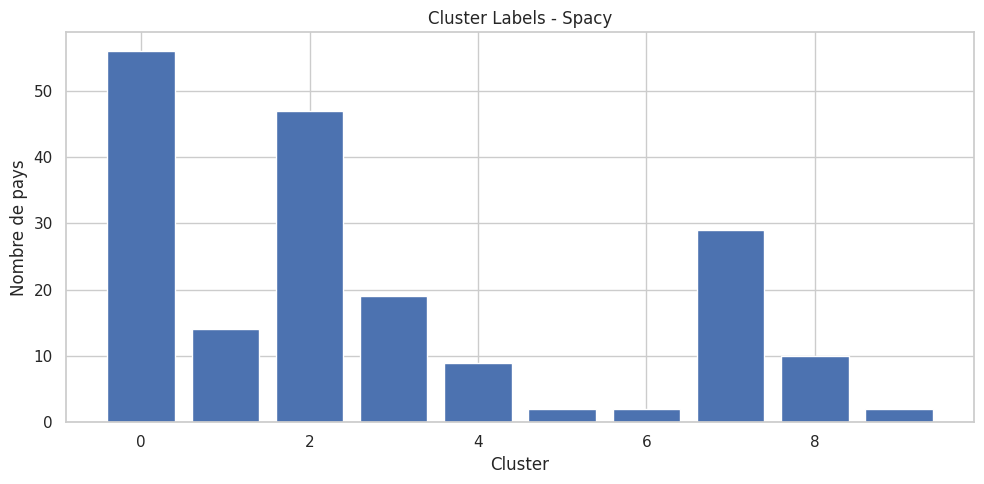

In [ ]:
import matplotlib.pyplot as plt

# Compter le nombre de pays dans chaque cluster pour Cluster_Labels_Spacy
spacy_counts = df['hierarCluster_Labels_Spacy'].value_counts()

# Créer une figure avec un seul axe
fig, ax = plt.subplots(figsize=(10, 5))

# Diagramme en barres pour Cluster_Labels_Spacy
ax.bar(spacy_counts.index, spacy_counts.values)
ax.set_title('Cluster Labels - Spacy')
ax.set_xlabel('Cluster')
ax.set_ylabel('Nombre de pays')

# Afficher le diagramme
plt.tight_layout()
plt.show()


Dans la suite logique de notre étude on continue toujours avec spacy

In [ ]:
hierarclustered_hymns_spacy = df.groupby('hierarCluster_Labels_Spacy')['Anthem_cleaned_spacy'].apply(list)
hierarclustered_hymns_spacy


hierarCluster_Labels_Spacy
0    [around flag stand unite one wish one goal sac...
1    [azerbaijan azerbaijan glorious fatherland val...
2    [belarusian peaceful people wholeheartedly dev...
3    [germany germany world protection defense alwa...
4    [god bless latvia beloved fatherland bless lat...
5    [day sun rise congo stand resplendent long nig...
6    [know thee old divinely restore light thine ey...
7    [land mountains land river land field land cat...
8    [hail grenada land pledge thee head heart hand...
9    [arise refuse slave flesh blood let build new ...
Name: Anthem_cleaned_spacy, dtype: object

In [ ]:
hierarclustered_countries_spacy = df.groupby('hierarCluster_Labels_Spacy')['Country'].apply(list)
hierarclustered_countries_spacy

hierarCluster_Labels_Spacy
0    [Albania, Armenia, Belgium, Czechia, Denmark, ...
1    [Azerbaijan, Iceland, Serbia, Switzerland, Bra...
2    [Belarus, Bulgaria, Georgia, Lithuania, Russia...
3    [Germany, Italy, Liechtenstein, Moldova (the R...
4    [Latvia, Trinidad and Tobago, Fiji, Solomon Is...
5    [Democratic Republic of Congo, Republic of the...
6                                     [Cyprus, Greece]
7    [Austria, Bosnia and Herzegovina, Croatia, Mal...
8    [Grenada, Antigua and Barbuda, New Zealand, Gh...
9                                       [China, Macau]
Name: Country, dtype: object

In [ ]:
cluster_keywords_hierar = cluster_keywords(hierarclustered_hymns_spacy)

In [ ]:
def hierarmerged_for_map(df,world,cluster_keywords):
  merged_data = world.merge(df, left_on='iso_a3', right_on='Alpha-3')

  # Convertir la colonne pour que plotly la considère comme catégorielle
  merged_data['hierarCluster_Labels_Spacy'] = merged_data['hierarCluster_Labels_Spacy'].astype('category')

  #Tooltip
  # Création de la colonne 'top_words_spacy' dans le dataframe
  merged_data['hierartop_words_spacy'] = merged_data['hierarCluster_Labels_Spacy'].apply(lambda x: ', '.join([word for word, count in cluster_keywords.get(x, [])]))

  return merged_data

In [ ]:
hierarmerged_data = hierarmerged_for_map(df,world,cluster_keywords_hierar)
hierarmerged_data.head()

pop_est      continent                      name iso_a3  gdp_md_est  \
0     889953.0        Oceania                      Fiji    FJI        5496   
1   58005463.0         Africa                  Tanzania    TZA       63177   
2     603253.0         Africa                 W. Sahara    ESH         907   
3   37589262.0  North America                    Canada    CAN     1736425   
4  328239523.0  North America  United States of America    USA    21433226   

                                            geometry  \
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...   
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...   

                    Country Alpha-3      Continent  \
0                      Fiji     FJI        Oceania   
1                  Tanzania     TZA         Africa   
2            Western Sahara     ESH         Africa   
3                    Canada     CAN  North_America   
4  United States of America     USA  North_America   

                                              Anthem  \
0  Blessing grant oh God of nations on the isles ...   
1  God bless Africa Bless its leaders Wisdom, uni...   
2  O sons of the Sahara! In the battlefield, you ...   
3  O Canada! Our home and native land! True patri...   
4  Oh, say can you see by the dawn's early light ...   

                                Anthem_cleaned_spacy  Cluster_Labels_Spacy  \
0  blessing grant god nation isle fiji stand unit...                     2   
1  god bless africa bless leader wisdom unity pea...                     4   
2  son sahara battlefield torch holder long road ...                    11   
3  canada home native land true patriot love thou...                     7   
4  say see dawn early light proudly hail twilight...                    12   

                              Anthem_cleaned_wordnet  \
0  blessing grant god nation isle fiji stand unit...   
1  god bless africa bless leader wisdom unity pea...   
2  son sahara battlefield torch holder long road ...   
3  canada home native land true patriot love thou...   
4  say see dawn early light proudly hailed twilig...   

  hierarCluster_Labels_Spacy  \
0                          4   
1                          4   
2                          0   
3                          7   
4                          0   

                               hierartop_words_spacy  
0  bless, god, land, may, fiji, protect, nation, ...  
1  bless, god, land, may, fiji, protect, nation, ...  
2  land, homeland, shall, live, glory, god, free,...  
3  land, love, free, thee, heart, canada, great, ...  
4  land, homeland, shall, live, glory, god, free,...

### Coude

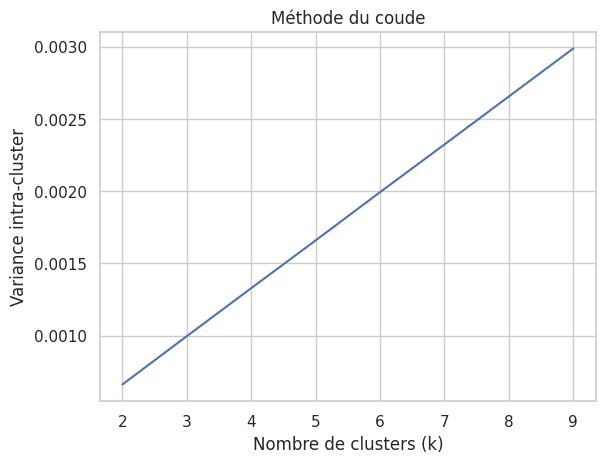

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
k_values = range(2,10)
variances = []
for k in k_values:
    clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = clustering.fit_predict(text_vectors_spacy.toarray())
    centers = np.array([np.mean(text_vectors_spacy.toarray()[labels == i], axis=0) for i in range(k)])
    variance = np.sum([np.var(text_vectors_spacy.toarray()[labels == i]) for i in range(k)])
    variances.append(variance)



plt.plot(k_values, variances)
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Variance intra-cluster')
plt.title('Méthode du coude')
plt.show()


Comme dans le kmean, la méthode coude ne dégage pas d'option claire.Par conséquent, on devra prendre en compte d'autres métriques, telles que le score de silhouette, pour une évaluation plus complète du nombre optimal de clusters.

### Silhouette

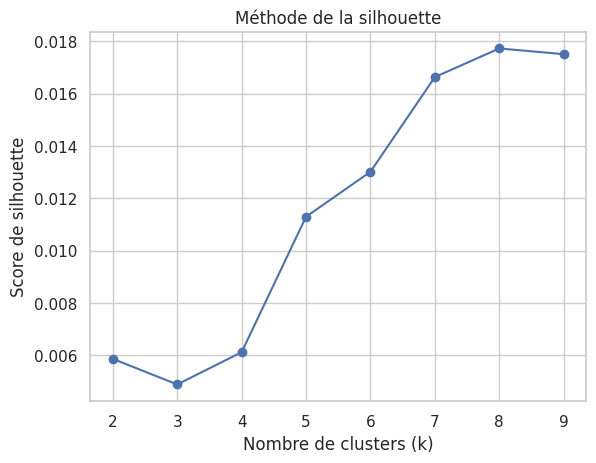

In [ ]:
import matplotlib.pyplot as plt

# Liste des valeurs de k à tester
k_values = range(2,10)

# Liste pour stocker les scores de silhouette
silhouette_scores = []

# Calculer le score de silhouette pour chaque valeur de k
for k in k_values:
    labels = part_hierarchical(text_vectors_spacy, k)
    silhouette_avg = silhouette_score(text_vectors_spacy, labels)
    silhouette_scores.append(silhouette_avg)

# Tracer le graphique de la méthode silhouette
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de silhouette')
plt.title('Méthode de la silhouette')
plt.xticks(k_values)
plt.show()


De meme l'allure de la courbe témoigne toujours de l'inefficacité du partitionnement

In [ ]:
silhouette_scores = []
for k in k_values:
    labels = part_hierarchical(text_vectors_spacy, k)
    silhouette_avg = silhouette_score(text_vectors_spacy.toarray(), labels)
    silhouette_scores.append(silhouette_avg)

best_k_silhouette = k_values[np.argmax(silhouette_scores)]
best_k_silhouette


8

In [ ]:
optimal_k = 8 # Valeur de k optimale déterminée précédemment
labels = part_hierarchical(text_vectors_spacy, optimal_k)
df['cluster'] = labels


Ajout au dataset original une variable “cluster“ indiquant pour chaque observation le cluster auquel elle appartient.

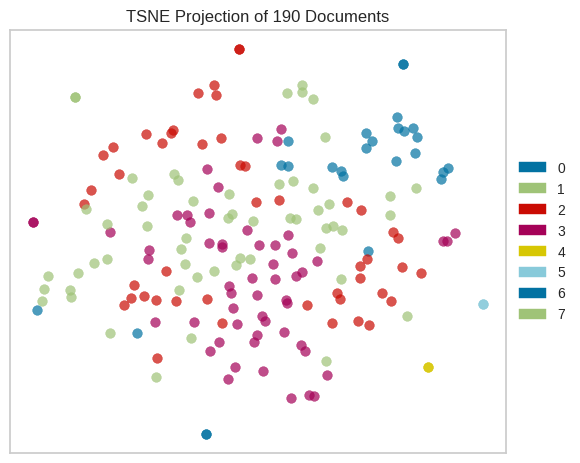

<Axes: title={'center': 'TSNE Projection of 190 Documents'}>

In [ ]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
tsne.fit_transform(text_vectors_spacy, labels)
tsne.show()


les points de différents clusters se superposent ou se mélangent, ceci indique une similarité élevée entre ces clusters. Cela peut être dû à une similarité élevée entre les textes ou à une difficulté à les séparer.

### Carte

In [ ]:
map_choropleth(hierarmerged_data,'hierarCluster_Labels_Spacy','hierartop_words_spacy','Clusters par pays')

De meme La carte  suggère que le partitionnement n'a peut-être pas réussi à capturer des distinctions thématiques claires mais fait sortir les similarités soit dans leurs régimes soit leurs proximités frontalières ou historiques.

In [ ]:
## Concaténer tous les hymnes nationaux d'un cluster en une seule chaîne de caractères
hierarcluster_keywords_spacy = cluster_keywords(hierarclustered_hymns_spacy)

### Wordcloud

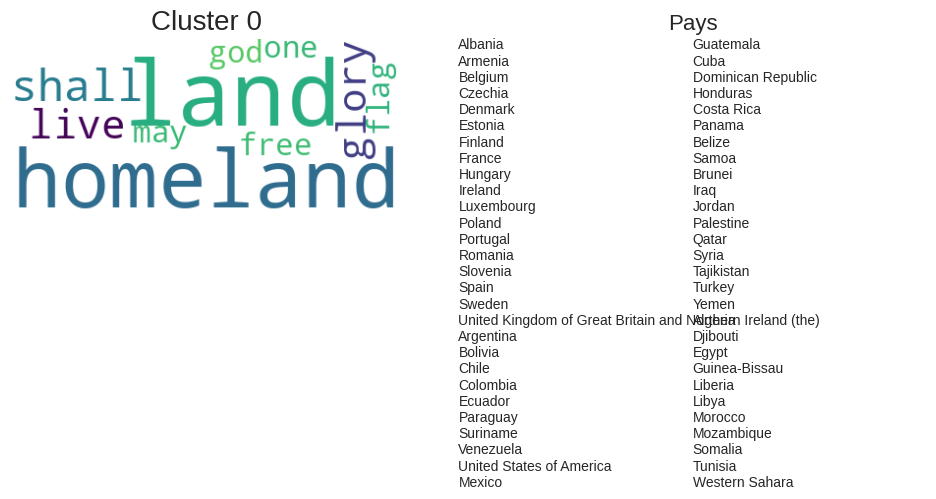

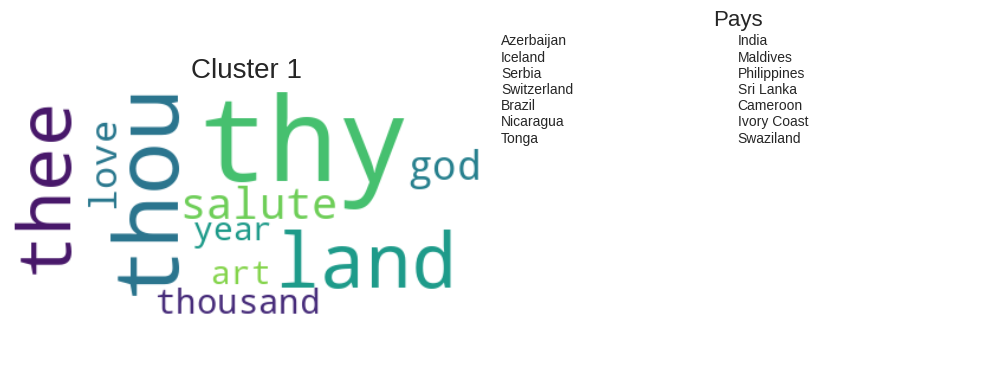

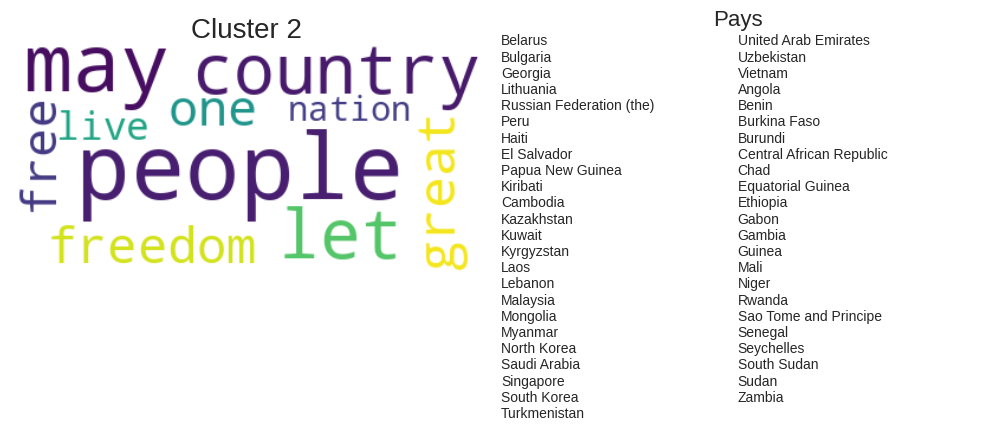

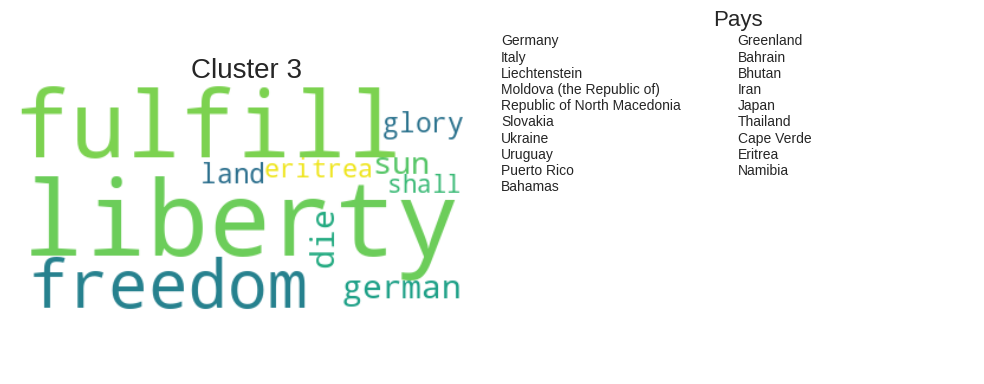

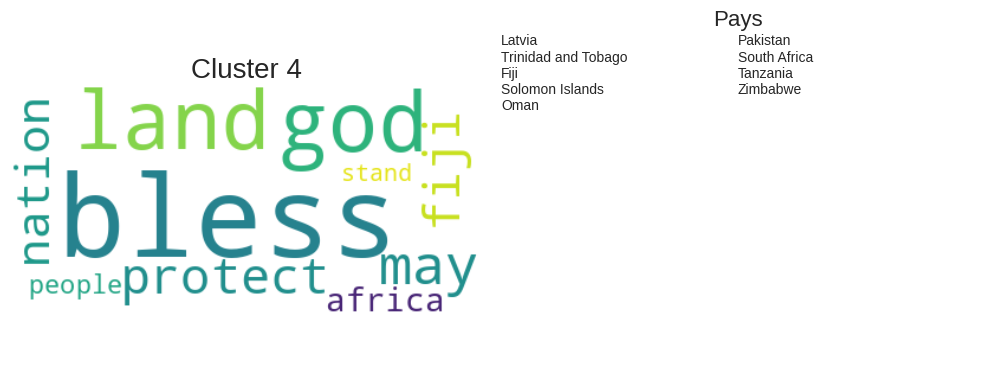

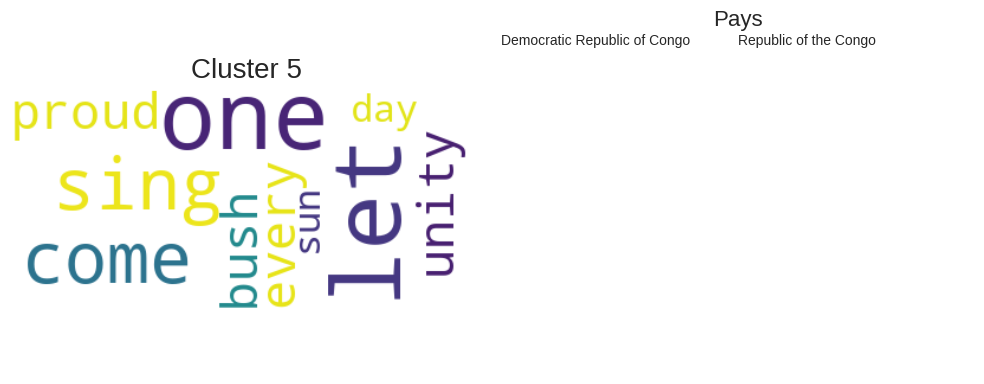

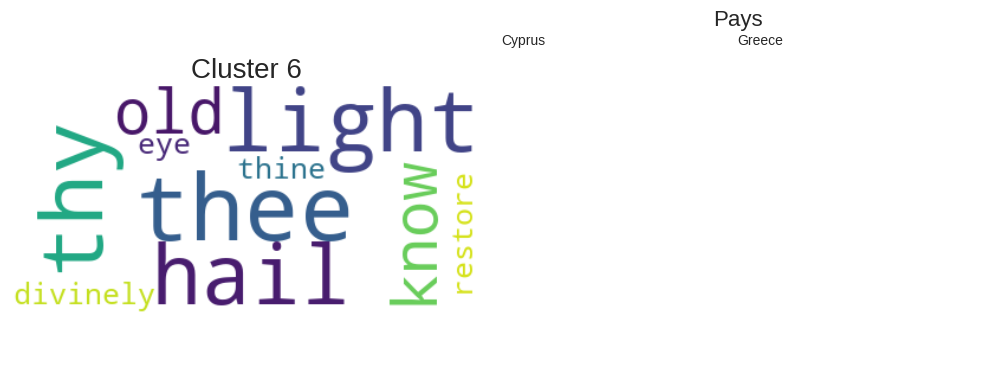

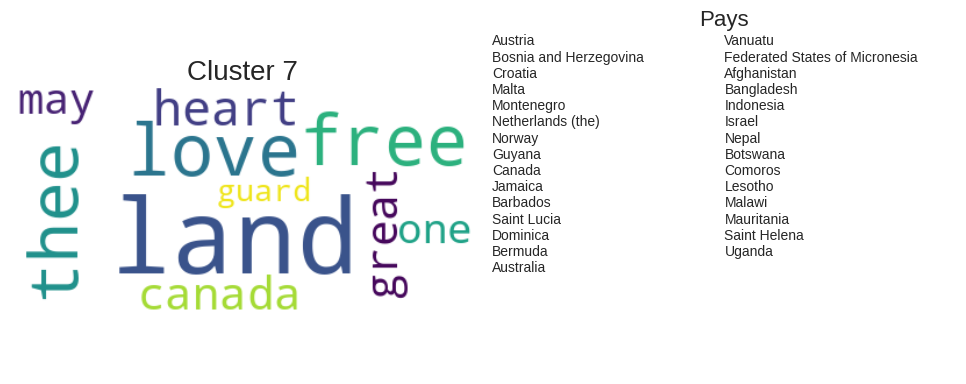

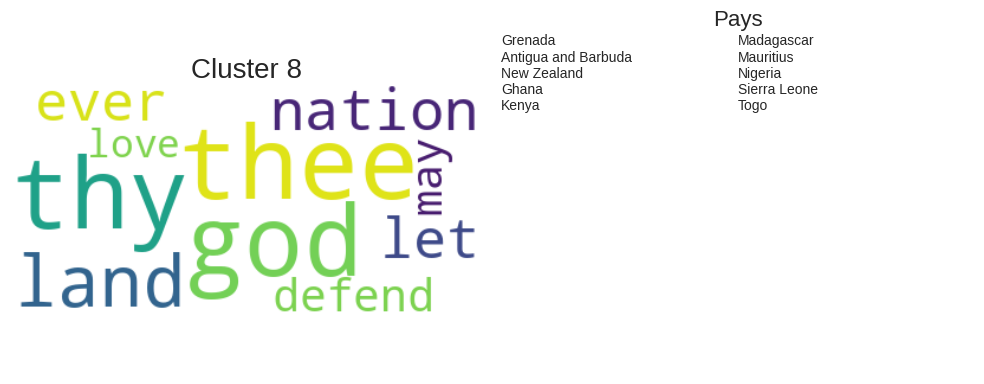

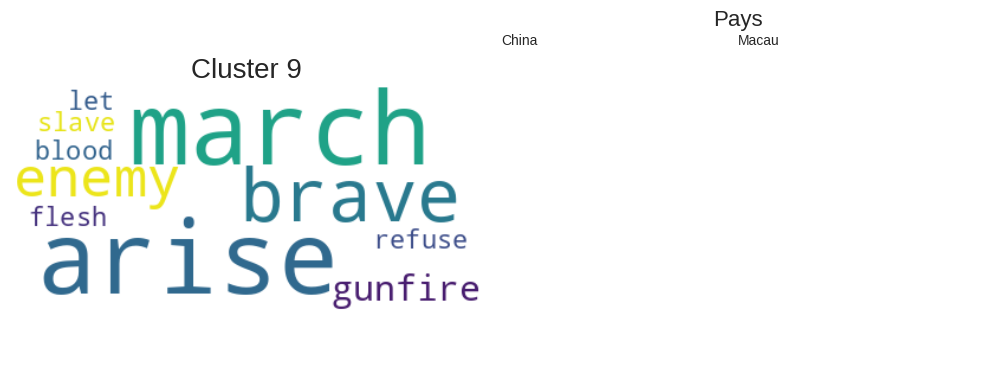

In [ ]:
display_wordcloud(hierarcluster_keywords_spacy,hierarclustered_countries_spacy)

Le nuage de mots généré pour chaque cluster met en évidence les termes les plus fréquents dans les hymnes nationaux de chaque groupe de pays. En observant les mots clés de chaque cluster, on identifie les thèmes et les concepts qui sont récurrents au sein de ces groupes. Cela permet d'avoir un aperçu des valeurs, des symboles ou des sujets importants pour chaque ensemble de pays, et d'identifier les similitudes et les différences entre les différents clusters.

## Nouveau Prétraitement

L'idée est d'axer l'étude cette fois sur 5 clusters afin de mettre l'accent sur les thématiques pertinentes des hymnes sachant que la recherche du cluster opotimal semble inefficace.


In [ ]:
# Classe qui hérite de la classe précédente.
# permet de définir des stop words personnalisés
# et de supprimer les doublons.
class CustomTextPreprocessor(TextPreprocessorSpacy):
    def __init__(self, additional_stopwords):
        super().__init__()
        self.stopwords = self.stopwords.union(set(additional_stopwords))

    def preprocess(self, text):
        processed_text = super().preprocess(text)

        # Supprimer les doublons
        tokens = processed_text.split()
        processed_text = ' '.join(list(set(tokens)))

        return processed_text


In [ ]:
# Déclaration
additional_stopwords = ['iceland','korean','brazil','canada']
custom_preprocessor = CustomTextPreprocessor(additional_stopwords=additional_stopwords)

In [ ]:
# Appliquer le prétraitement des textes sur la colonne "Anthem"
df['Anthem_cleaned_spacy'] = df['Anthem'].apply(custom_preprocessor.preprocess) # 3ième itération

In [ ]:
# Vectorisation
text_vectors_spacy = vectorizer.fit_transform(df['Anthem_cleaned_spacy'])
tfidf_spacy = pd.DataFrame(text_vectors_spacy.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_spacy.head()

4th  abandon  abanyarwanda  abide  ablaze  able  abound  absolute  abstain  \
0  0.0      0.0           0.0    0.0     0.0   0.0     0.0       0.0  0.19204   
1  0.0      0.0           0.0    0.0     0.0   0.0     0.0       0.0  0.00000   
2  0.0      0.0           0.0    0.0     0.0   0.0     0.0       0.0  0.00000   
3  0.0      0.0           0.0    0.0     0.0   0.0     0.0       0.0  0.00000   
4  0.0      0.0           0.0    0.0     0.0   0.0     0.0       0.0  0.00000   

   abundance  ...  zeal  zealand  zealous  zenith  zimbabwe  zion  ºciuszko  \
0        0.0  ...   0.0      0.0      0.0     0.0       0.0   0.0       0.0   
1        0.0  ...   0.0      0.0      0.0     0.0       0.0   0.0       0.0   
2        0.0  ...   0.0      0.0      0.0     0.0       0.0   0.0       0.0   
3        0.0  ...   0.0      0.0      0.0     0.0       0.0   0.0       0.0   
4        0.0  ...   0.0      0.0      0.0     0.0       0.0   0.0       0.0   

   ãƒâ     œende  šawice  
0  0.0  0.000000     0.0  
1  0.0  0.000000     0.0  
2  0.0  0.000000     0.0  
3  0.0  0.200369     0.0  
4  0.0  0.000000     0.0  

[5 rows x 2973 columns]

In [ ]:
#Appliquer le partitionnement hiérarchique sur 5 CLUSTERS
labels = part_hierarchical(text_vectors_spacy, 5)


## Carte

In [ ]:
labels_hierar = part_hierarchical(text_vectors_spacy, 5)  # Utilisez votre fonction part_hierarchical avec le nombre optimal de clusters
df['Cluster_Labels_Hierar'] = labels_hierar
merged_data = merged_for_map(df, world,cluster_keywords_spacy)
map_choropleth(merged_data, 'Cluster_Labels_Hierar', 'top_words_spacy', 'Clusters par pays - Partitionnement hiérarchique')

In [ ]:
clustered_hymns_spacy = df.groupby('Cluster_Labels_Hierar')['Anthem_cleaned_spacy'].apply(list)
clustered_countries_spacy = df.groupby('Cluster_Labels_Hierar')['Country'].apply(list)
cluster_keywords_spacy = cluster_keywords(clustered_hymns_spacy)


In [ ]:
for cluster, keywords in cluster_keywords_spacy.items():
    print(f"Cluster {cluster}: {keywords[:5]}")


Cluster 0: [('land', 78), ('people', 52), ('nation', 49), ('god', 48), ('glory', 47)]
Cluster 1: [('god', 26), ('peace', 24), ('land', 21), ('may', 20), ('nation', 16)]
Cluster 2: [('critical', 2), ('everybody', 2), ('million', 2), ('gunfire', 2), ('slave', 2)]
Cluster 3: [('restore', 2), ('grave', 2), ('thy', 2), ('thee', 2), ('thine', 2)]
Cluster 4: [('triumph', 2), ('day', 2), ('bush', 2), ('die', 2), ('ocean', 2)]


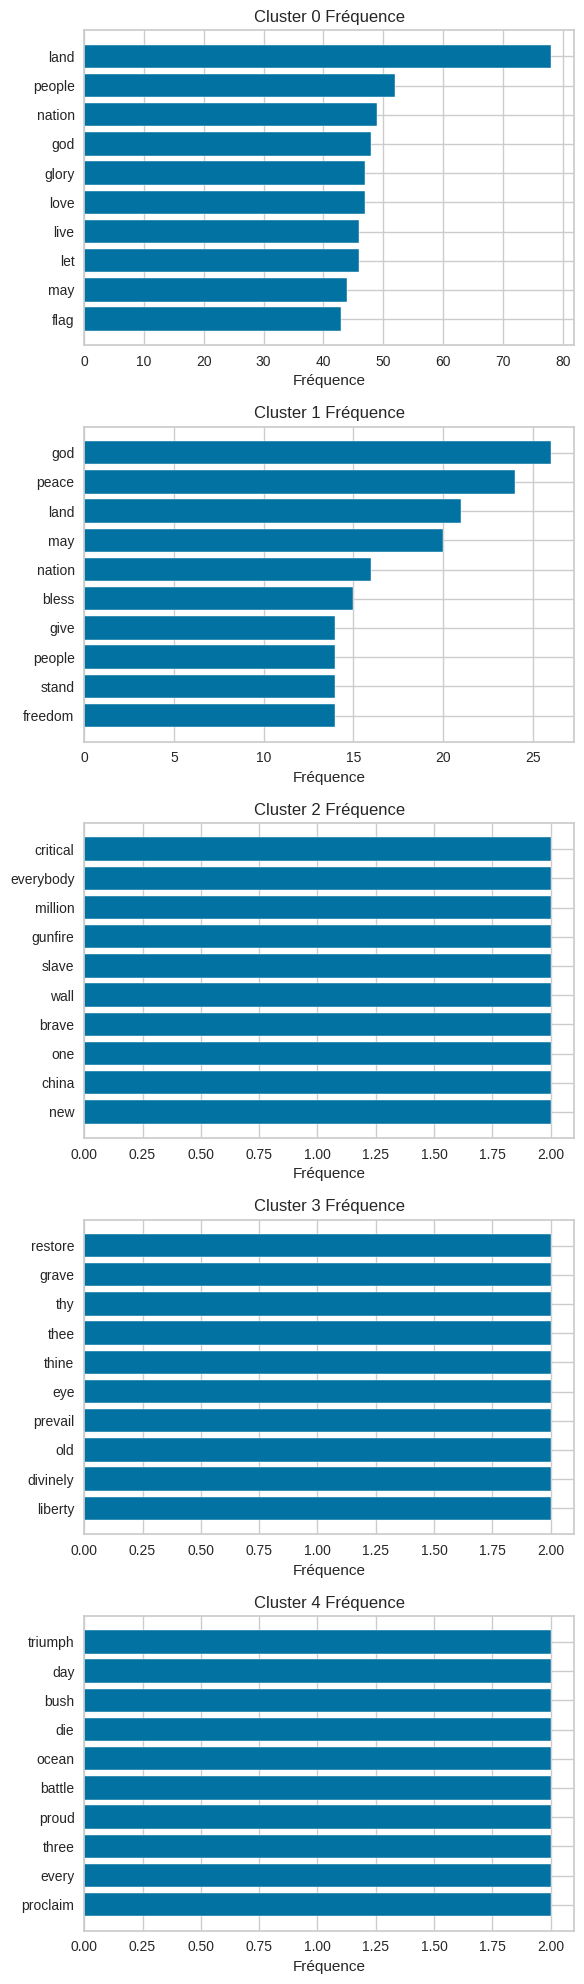

In [ ]:
barplot_word_freq_barplot(cluster_keywords_spacy)


### Analyse Thématique des clusters



Cluster 0 : **"Terre et peuple"**

Ce cluster met en avant les mots-clés liés à la terre, au peuple et à la nation, suggérant un fort sentiment d'attachement à la patrie.
Les mots "land", "people" et "nation" sont particulièrement représentatifs de ce thème.

Cluster 1 : **"Paix et spiritualité"**

Ce cluster met l'accent sur les notions de paix, de spiritualité et de l'importance de la foi.
Le mot "god" est prédominant, soulignant l'importance de la spiritualité et de la croyance religieuse.

Cluster 2 : **"Identité et résistance"**

Ce cluster présente des mots-clés tels que "critical", "china", "defiance", suggérant un thème lié à l'identité nationale et à la résistance.
Il met en avant l'idée de l'unité et de la force face à des défis.

Cluster 3 : **"Lumière et connaissance"**

Ce cluster met en avant les notions de lumière, de connaissance et de sagesse.
Les mots "light", "eye" et "know" évoquent l'idée de la recherche de la vérité et de la compréhension.

Cluster 4 : **"Unité et fierté nationale"**

Ce cluster met en valeur l'idée de l'unité et de la fierté nationale, avec une référence aux symboles tels que l'océan et la lutte.
Les mots "ocean", "fight" et "united" soulignent l'importance de l'unité pour faire face aux défis et de la fierté nationale.



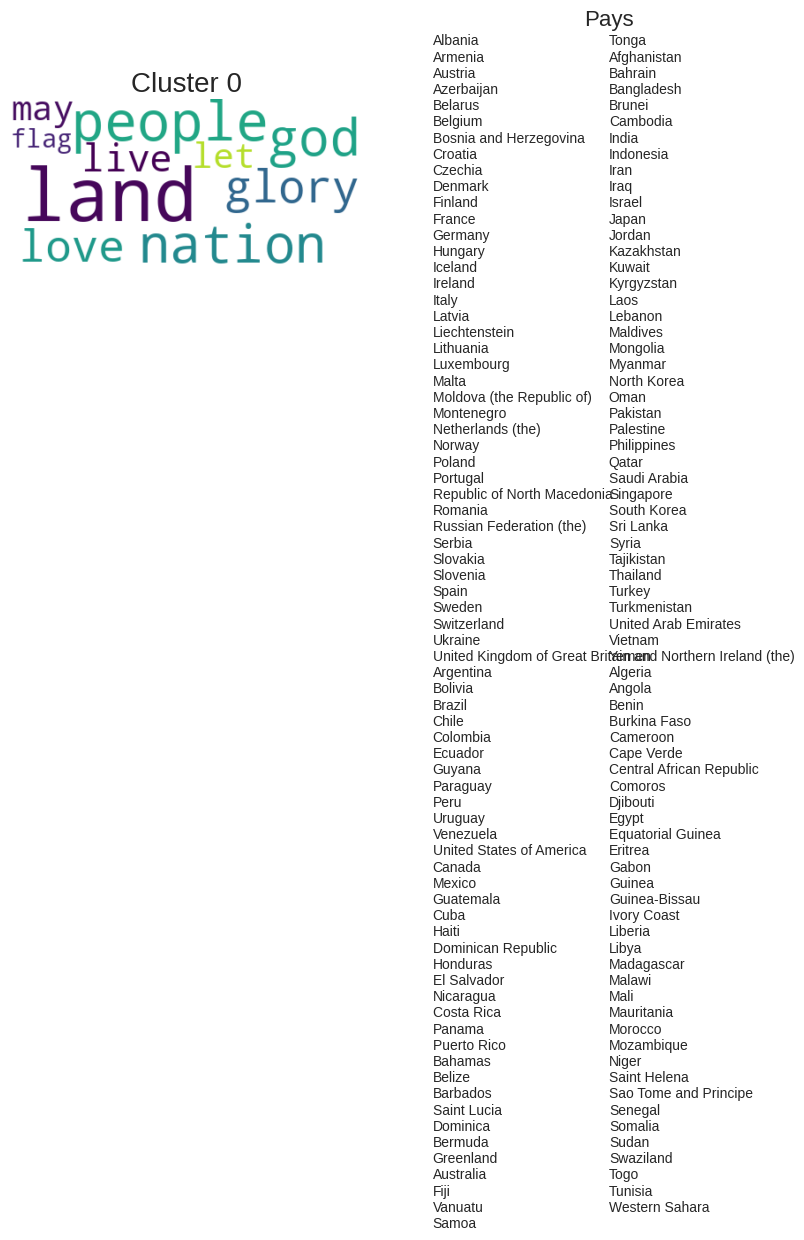

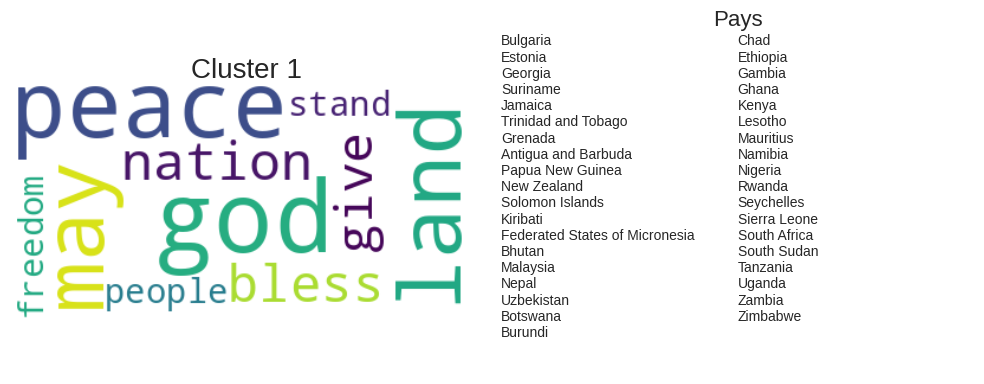

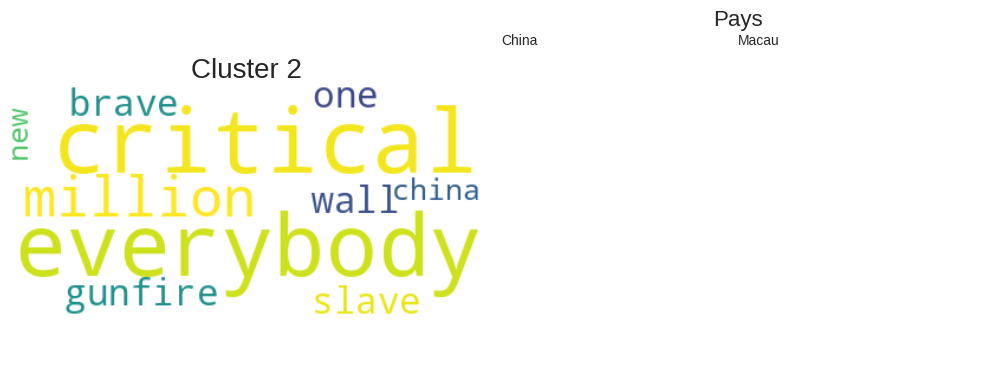

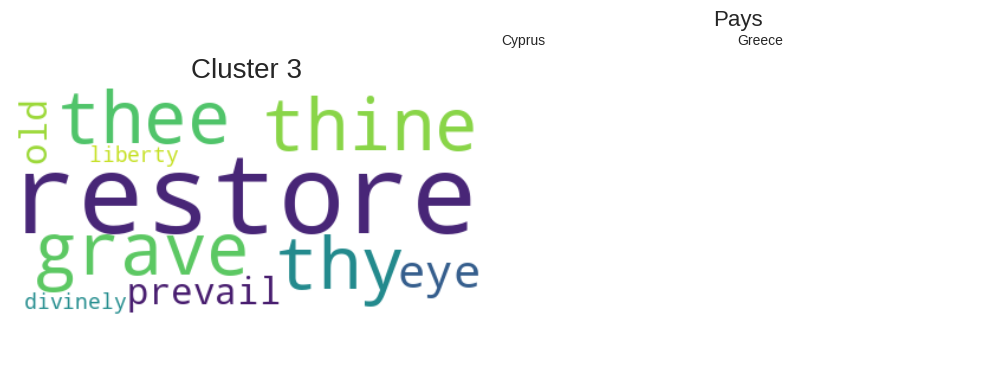

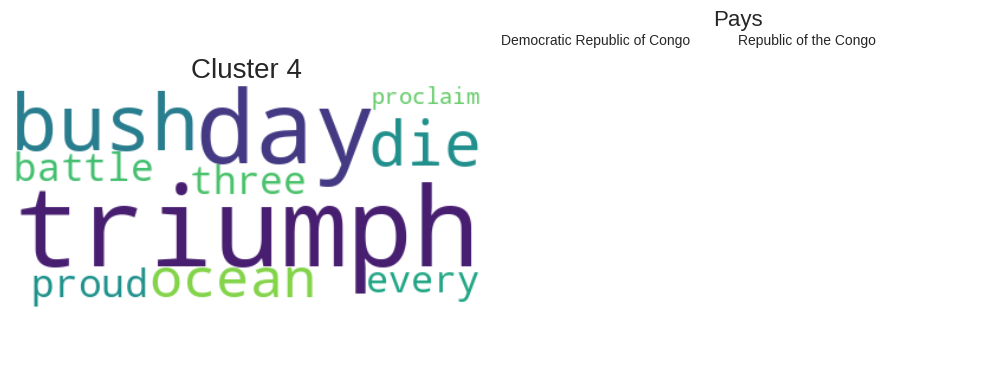

In [ ]:
display_wordcloud(cluster_keywords_spacy,clustered_countries_spacy)

### Nuage de points

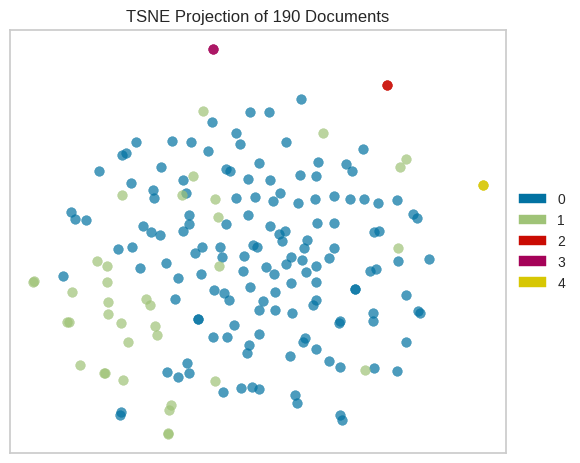

<Axes: title={'center': 'TSNE Projection of 190 Documents'}>

In [ ]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
tsne.fit_transform(text_vectors_spacy, labels_hierar )
tsne.show()


### Nouveau Dendrogramme

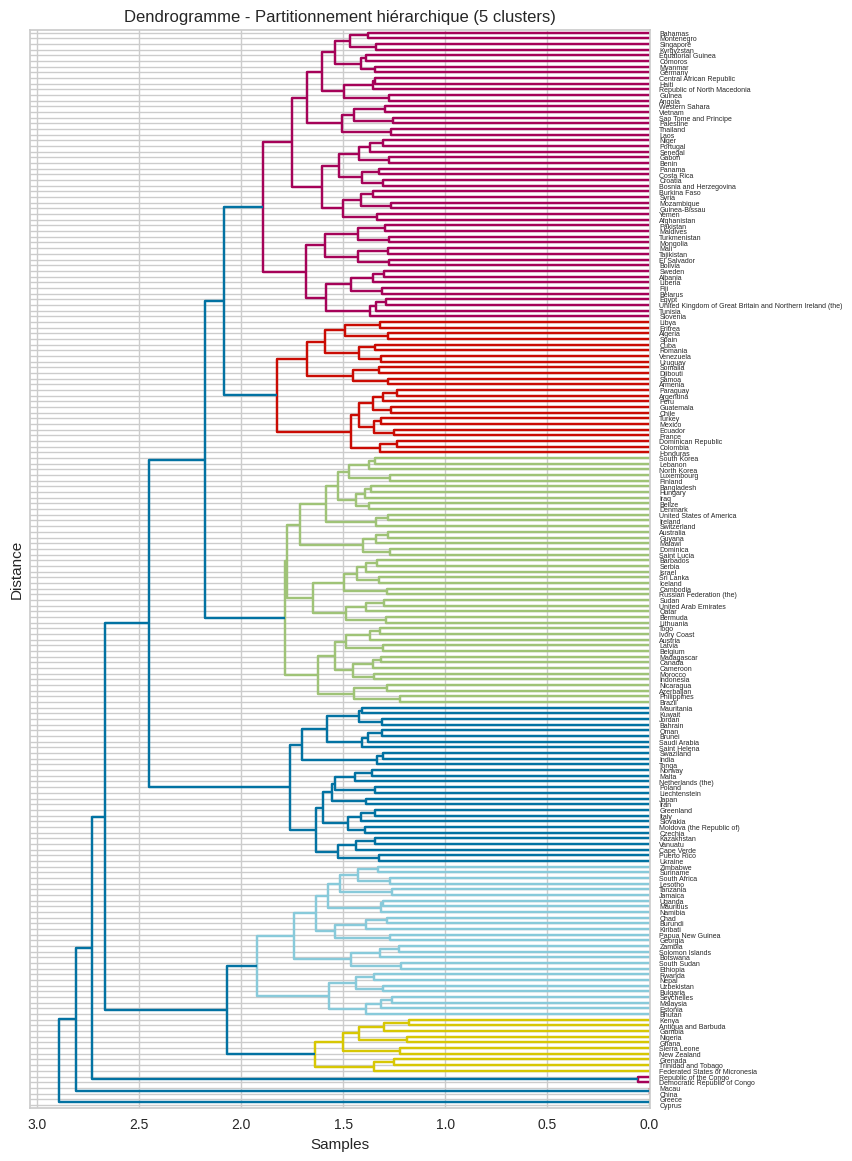

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances

# Ignorer les avertissements
warnings.filterwarnings("ignore")

def part_hierarchical(text_vectors, k):
    distance_matrix = pairwise_distances(text_vectors, metric='cosine')
    clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = clustering.fit_predict(distance_matrix)
    return labels

labels = part_hierarchical(text_vectors_spacy, 5)

# Calculer la distance matrix
distance_matrix = pairwise_distances(text_vectors_spacy, metric='cosine')

# Compute the linkage matrix using the distance matrix
linkage_matrix = linkage(distance_matrix, method='ward')
plt.figure(figsize=(8, 14))
# Plot the dendrogram
dendrogram(linkage_matrix, labels=df['Country'].values, orientation='left')

# Add labels to the plot
plt.title("Dendrogramme - Partitionnement hiérarchique (5 clusters)")
plt.xlabel("Samples")
plt.ylabel("Distance")

# Show the plot
plt.show()



Le dendrogramme du partitionnement hiérarchique révèle une structuration des pays en fonction de similarités thématiques dans leurs hymnes nationaux.En résumé les regroupements obtenus mettent en évidence des thèmes tels que l'attachement à la terre et au peuple, la paix et la spiritualité, l'identité nationale et la résistance, la lumière et la connaissance, ainsi que l'unité et la fierté nationale.

## Conclusion
Malgré la difficulté à déterminer un nombre optimal de clusters de manière objective, l'approche guidée par l'objectif métier a permis de choisir un partitionnement en 5 clusters qui offre une compréhension efficace des thèmes principaux des hymnes dans le sens ou Chaque cluster représente des concepts spécifiques qui émergent à partir des paroles des hymnes.


**De manière générale**


Les techniques d'évaluation, telles que la méthode du coude et la silhouette, pour tenter de déterminer le nombre optimal de clusters. Cependant, les résultats n'ont pas été concluants en raison du chevauchement significatif entre les clusters et de la complexité de l'interprétation avec un nombre élevé de clusters.
**En dernier lieu**
Le partitionnement hiérarchique a été utilisé comme alternative pour analyser les clusters avec la méthode "ward" et en regroupant les hymnes en cinq clusters.